# Give Me Some Credit

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [168]:
random_state = 1

# Charger les données

In [169]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

In [170]:
data.loc[data.MonthlyIncome.isnull(), 'MonthlyIncome'] = data.MonthlyIncome.median()
data.loc[data.NumberOfDependents.isnull(), 'NumberOfDependents'] = data.NumberOfDependents.median()

In [175]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

Normalisation à l'aide de QuantileTransformer dans le but de supprimer l'influence des outliers sur la prédiction.

In [ ]:
X_normalized = QuantileTransformer().fit_transform(X.values)

data_normalized = pd.DataFrame(X_normalized, columns=X.columns, index=X.index)
data_normalized['SeriousDlqin2yrs'] = data.SeriousDlqin2yrs

On fait un premier nettoyage des données qui consiste à remplacer les blancs par des médianes.

In [17]:
feature_names = np.array(X.columns)
X.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,249.755371,14.771866,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


# Essai de plusieurs modèles simples

In [18]:
from sklearn.metrics import roc_curve, auc

In [172]:
clfs = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=10, random_state=random_state),
    'LogisticRegression': LogisticRegression(solver='lbfgs', random_state=random_state),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=random_state),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=random_state),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'MLPClassifier': MLPClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(3),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5),
    'GaussianNB': GaussianNB()
}

In [173]:
def fit_and_score_clfs(clfs, X=X, y=y, test_size=0.9):
    '''
        Given a dict of classifiers, return a dict of scores obtained by fitting each classifier
        on the set (X, y) with the given test_proportion

        clfs: dict of classifiers
                key: name of clf
                value: clf object
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scores = dict()
    for name, clf in clfs.items():
        clf.fit(X_train, y_train)
        scores[name] = clf.score(X_test, y_test)

    return scores

Scores sur données brutes.

In [174]:
fit_and_score_clfs(clfs)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'RandomForestClassifier': 0.933274074074074,
 'LogisticRegression': 0.9331925925925926,
 'GradientBoostingClassifier': 0.9358444444444445,
 'ExtraTreesClassifier': 0.9307555555555556,
 'AdaBoostClassifier': 0.9357185185185185,
 'MLPClassifier': 0.9322666666666667,
 'KNeighborsClassifier': 0.9246074074074074,
 'DecisionTreeClassifier': 0.9351851851851852,
 'GaussianNB': 0.9326814814814814}

Scores sur données normalisées avec QuantileTransformer

In [176]:
fit_and_score_clfs(clfs, X=X_normalized)

{'RandomForestClassifier': 0.9334444444444444,
 'LogisticRegression': 0.9363259259259259,
 'GradientBoostingClassifier': 0.9357629629629629,
 'ExtraTreesClassifier': 0.930962962962963,
 'AdaBoostClassifier': 0.9357185185185185,
 'MLPClassifier': 0.934637037037037,
 'KNeighborsClassifier': 0.9243703703703704,
 'DecisionTreeClassifier': 0.9351555555555555,
 'GaussianNB': 0.9082814814814815}

## Influence de la normalisation
Étudions l'influence de la normalisation sur les scores

In [177]:
def cross_validate_clfs(clfs, X=X, y=y, cv=5):
    scores = dict()
    
    for name, clf in clfs.items():
        print('Cross validating {}...'.format(name))
        scores[name] = np.mean(cross_validate(clf, X, y, cv=cv)['test_score'])

    return scores

In [178]:
def plot_scores(clfs, X_dict, y, y_label, score_function, **kwargs):
    df_list = []
    for data_name, data in X_dict.items():
        scores = score_function(clfs, X=data, y=y, **kwargs)

        for clf_name, score in scores.items():
            df_list.append([data_name, clf_name, score])

    df = pd.DataFrame(df_list, columns=['Data', 'clf_name', 'score'])
    print(df)

    max_row = df.loc[df['score'].argmax()]
    print('Maximum atteint pour :\n {}'.format(max_row))

    g = sns.catplot(x="clf_name", y="score", hue="Data", data=df,
                    height=6, kind="bar", palette="muted")
    g.despine(left=True)
    g.set_ylabels(y_label)
    plt.xticks(rotation=90)
    plt.ylim(bottom=0.8)
    plt.axhline(max_row['score'], color='r')
    plt.show()

Cross validating RandomForestClassifier...
Cross validating LogisticRegression...


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Cross validating GradientBoostingClassifier...
Cross validating ExtraTreesClassifier...
Cross validating AdaBoostClassifier...
Cross validating MLPClassifier...
Cross validating KNeighborsClassifier...
Cross validating DecisionTreeClassifier...
Cross validating GaussianNB...
Cross validating RandomForestClassifier...
Cross validating LogisticRegression...
Cross validating GradientBoostingClassifier...
Cross validating ExtraTreesClassifier...
Cross validating AdaBoostClassifier...
Cross validating MLPClassifier...
Cross validating KNeighborsClassifier...
Cross validating DecisionTreeClassifier...
Cross validating GaussianNB...
          Data                    clf_name     score
0          Raw      RandomForestClassifier  0.933333
1          Raw          LogisticRegression  0.933187
2          Raw  GradientBoostingClassifier  0.937260
3          Raw        ExtraTreesClassifier  0.930933
4          Raw          AdaBoostClassifier  0.935567
5          Raw               MLPClassifier  0.93

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if sys.path[0] == '':


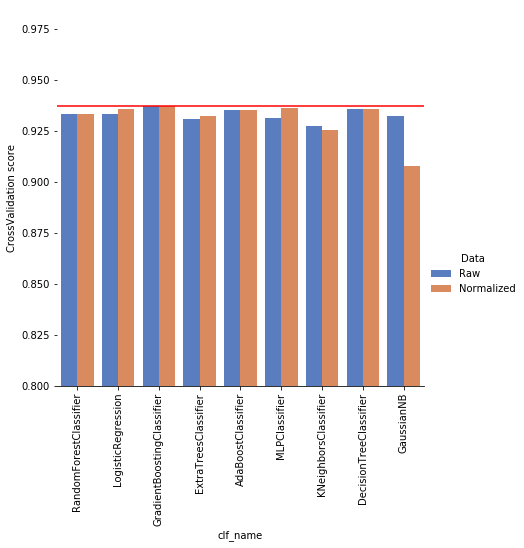

In [179]:
    X_dict = {
        'Raw': X,
        'Normalized': X_normalized
    }
    plot_scores(clfs, X_dict, y, 'CrossValidation score', score_function=cross_validate_clfs, cv=5)


La normalisation n'a pas un effet unanime sur les scores des classifieurs. Pour certains d'entre eux, elle améliore les résultats (LogisitcRegression, ExtraTreesClassifier, MLPClassifier) alors que pour d'autres elle altère les résultats (KNeighborsClassifier, GaussianNB). D'autres classifiers semblent invariant à la normalisation (RandomForestClassifier, GradientBoostingClassifier, AdaboostClassifier et DecisionTreeClassifier). Le maximum est d'ailleurs atteint pour GradientBoostingClassifier avec un score de CrossValidation de 0.938 et ne présente pas de différence de score entre les données brutes ou normalisées. Ainsi, par la suite nous continueront de travailler sur les données brutes.

In [22]:
def eval_model(mod, X, y, name=None, CVNFOLDS=7):
    cv = StratifiedKFold(n_splits=CVNFOLDS)
    mem = []
    for i, (training, test) in enumerate(cv.split(X, y)):
        fit = mod.fit(X.iloc[training], y.iloc[training])
        prob = fit.predict_proba(X.iloc[test])
        fpr, tpr, _ = roc_curve(y.iloc[test], prob[:, 1])
        a = auc(fpr, tpr)
        mem.append(a)
        #print('ROC: %f' % a)
        plt.plot(fpr, tpr)
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title(name)
    plt.show()
    print("Mean: %f" % np.mean(mem))

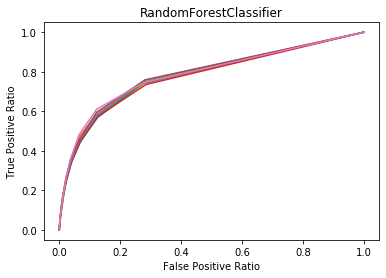

Mean: 0.782206


/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations

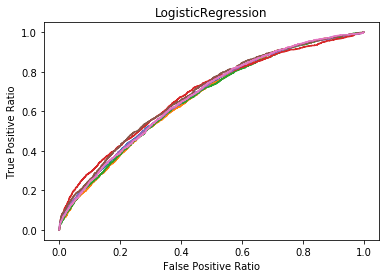

Mean: 0.674192


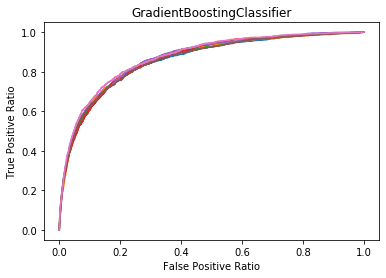

Mean: 0.864376


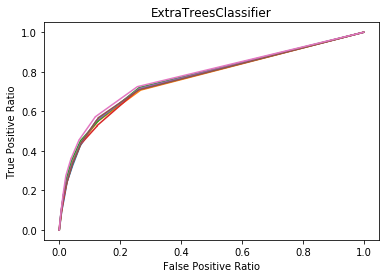

Mean: 0.766276


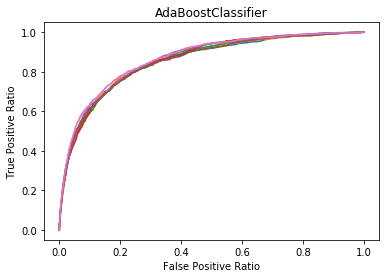

Mean: 0.858934


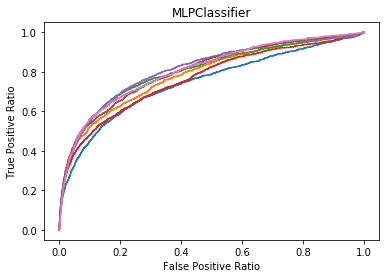

Mean: 0.787918


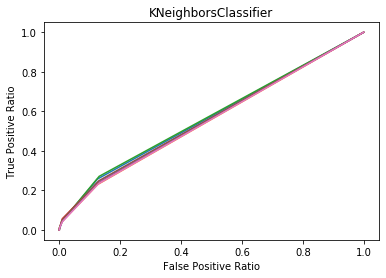

Mean: 0.560895


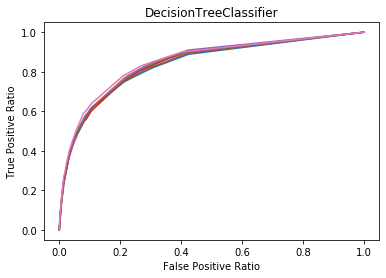

Mean: 0.843615


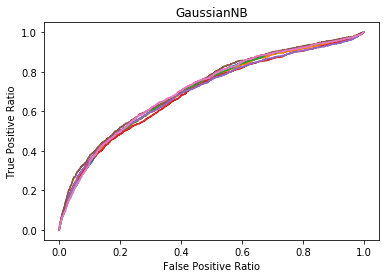

Mean: 0.705704


In [12]:
for name, clf in clfs.items():
    eval_model(clf, X, y, name=name)


# Visualisation des données

In [164]:
def visualization(data):
    # # B/M plot
    plt.barh(['no problem', 'seriousProblemIn2Years'], [np.sum(y == 1), np.sum(y == 0)])
    plt.xlabel('Nombre d\'entrées')
    plt.show()

    # Violin plot
    X = data.drop('SeriousDlqin2yrs', axis=1)
    data_normalized = pd.DataFrame(QuantileTransformer().fit_transform(X.values), columns=X.columns, index=X.index)
    data_normalized['SeriousDlqin2yrs'] = data.SeriousDlqin2yrs
    data_melt = data_normalized.melt(id_vars=['SeriousDlqin2yrs'])
    sns.violinplot(x='variable', y='value', hue='SeriousDlqin2yrs',
               split=True, inner="quart",
               scale='area',
               data=data_melt)
    sns.despine(left=True)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.show()

    # Correlation
    # Compute the correlation matrix
    corr = X.corr()

    # # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # # Draw the heatmap with the mask and correct aspect ratio
    f, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".1f", linewidths=.7)
    plt.show()

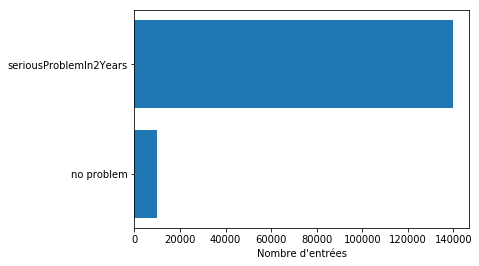

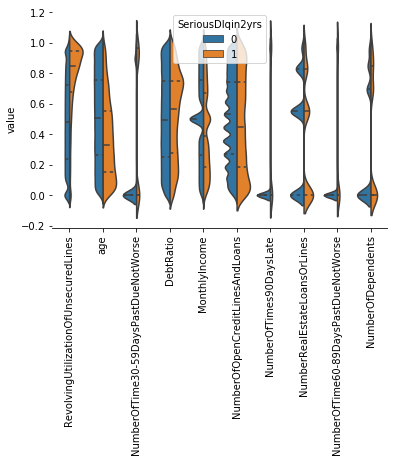

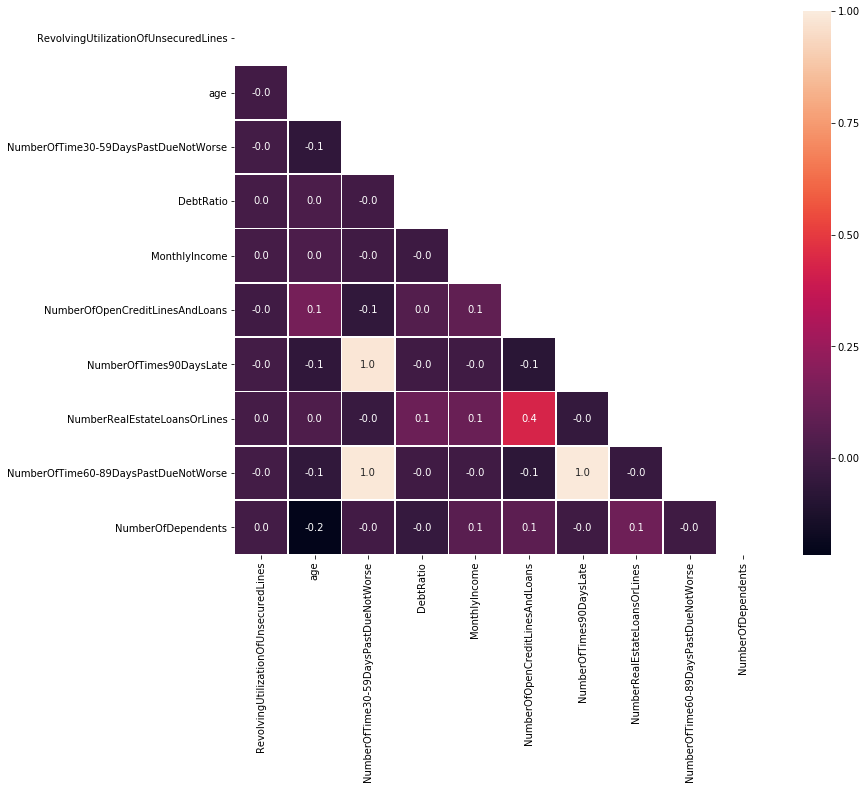

In [165]:
visualization(data)

### Distribution des features
Pour permettre l'affichage et l'interprétation des distributions, le Scaler QuantileTransformer a été appliqué aux données avant l'affichage. Il s'agit d'un Scaler robuste qui permet nottament de ne pas tenir compte des outliers qui auraient empêché ici l'interprétation. Le Scaler n'est utilisé que pour l'affichage, un traitement des outliers sera fait dans la partie Nettoyage des données.

Pour la plupart features, on remarque que les distributions sont plutôt équilibrées entre clients à problèmes et sans problèmes. Cependant l'age et RevolvingUtilizationOfUnsecuredLines semble être plus discriminante que les autres features. Un client plus agé aura moins de chance de présenter un défaut de payment par la suite. C'est quelque chose que nous pourrons essayer de vérifier lors de l'étude de l'importance des features.

### Corrélation
À l'exception de NumberOfTime90DaysLate et NumberOfTime60-89DaysPastDueNotWorse, on remarque que les features sont très décorrélées. Ceci implique qu'une PCA a peu de chance de donner des résultats de qualité équivalente pour un temps d'entrainement moins long. Pour s'en convaincre, traçons le diagramme d'éboulis :

In [15]:
def find_optimal_dimension(data, explained_proportion, show=False):
    '''
        Return how many dimensions to keep to explain a given proportion of the data.
        Informative purpose only since this feature is already implemented in sklearn.
        Use PCA(n_components=explained_proportion) instead.

        data : array of shape (n_samples, n_features)
        explained_proportion : float in [0, 1]
    '''
    p = data.shape[1]
    pca = PCA(data.shape[1])

    # Important : Normalize data to have homogenous features
    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', pca)])
    data = pipeline.fit_transform(data)

    # Determine how many components to keep
    explained_ratio = np.cumsum(pca.explained_variance_ratio_)
    for k in range(len(explained_ratio)):
        if explained_ratio[k] >= explained_proportion:
            p=k+1
            break
    print('Keeping {} components to explain {}% of the variance'.format(p, 100*explained_proportion))

    if show:
        eigen_values = pca.explained_variance_
        plt.plot(range(len(eigen_values)), eigen_values)
        plt.axvline(p, c='orange')
        plt.xlabel('Eigenvalue index')
        plt.ylabel('Eigenvalue')
        plt.title('Keeping {} components to explain {}% of the variance'.format(p, 100*explained_proportion))
        plt.show()        

    return p

Keeping 9 components to explain 99.0% of the variance


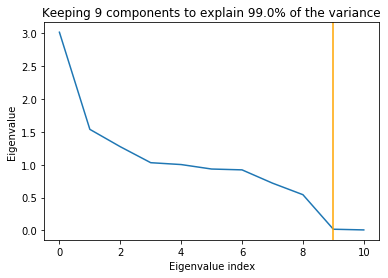

9

In [16]:
find_optimal_dimension(data, .99, show=True)

Sans surprise seule une feature peut être enlevée tout en gardant 99% de la variance expliquée. Cela est cohérent avec la matrice de corrélation étudiée précédemment dans laquelle uniquement 2 features étaient très corrélées.

# Nettoyage des données

In [226]:
from collections import Counter

On reprend un jeu de données propre :

In [227]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

### Age

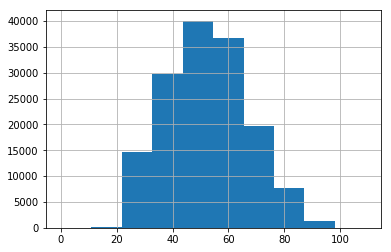

In [228]:
data.age.hist()

In [229]:
Counter(data[data.age<30].age)

Counter({27: 1338,
         25: 953,
         24: 816,
         28: 1560,
         26: 1193,
         29: 1702,
         23: 641,
         22: 434,
         21: 183,
         0: 1})

Une personne est agée de 0 an, c'est probablement une erreur. On le remplace par la médiane.

In [230]:
data.loc[data.age < 21, 'age'] = data.age.median()

In [231]:
Counter(data[data.age>100].age)

Counter({101.0: 3, 103.0: 3, 102.0: 3, 107.0: 1, 105.0: 1, 109.0: 2})

### NumberOfTime30-59DaysPastDueNotWorse

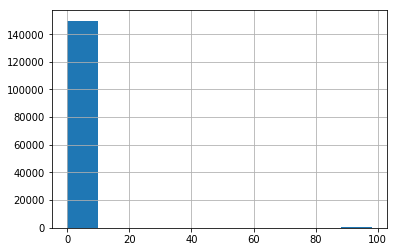

In [232]:
data["NumberOfTime30-59DaysPastDueNotWorse"].hist()

On suppose que les valeurs 98 et 96 sont des erreurs.

In [233]:
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

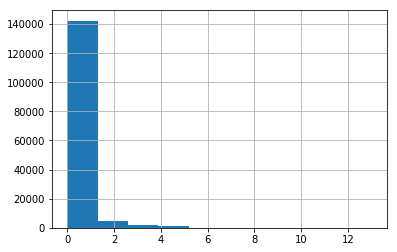

In [234]:
data["NumberOfTime30-59DaysPastDueNotWorse"].hist()

### NumberOfTimes90DaysLate

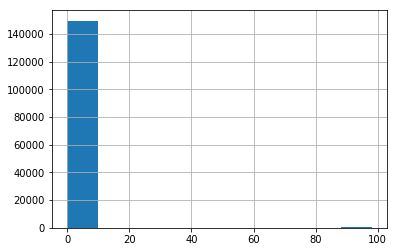

In [235]:
data.NumberOfTimes90DaysLate.hist()

In [236]:
Counter(data.NumberOfTimes90DaysLate)

Counter({0: 141662,
         1: 5243,
         3: 667,
         2: 1555,
         5: 131,
         4: 291,
         98: 264,
         10: 8,
         9: 19,
         6: 80,
         7: 38,
         8: 21,
         15: 2,
         96: 5,
         11: 5,
         13: 4,
         14: 2,
         17: 1,
         12: 2})

On suppose encore que les valeurs 96 et 98 sont des erreurs.

In [237]:
data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

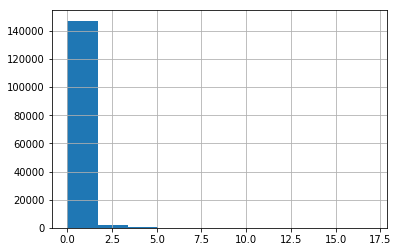

In [238]:
data.NumberOfTimes90DaysLate.hist()

### NumberRealEstateLoansOrLines¶

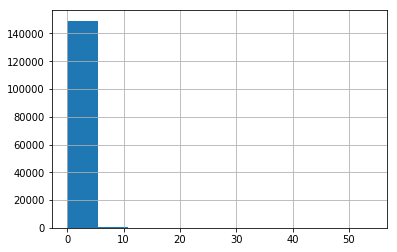

In [239]:
data.NumberRealEstateLoansOrLines.hist()

In [240]:
Counter(data.NumberRealEstateLoansOrLines)

Counter({6: 320,
         0: 56188,
         1: 52338,
         3: 6300,
         4: 2170,
         2: 31522,
         5: 689,
         8: 93,
         7: 171,
         9: 78,
         17: 4,
         15: 7,
         10: 37,
         12: 18,
         11: 23,
         16: 4,
         26: 1,
         14: 7,
         54: 1,
         21: 1,
         18: 2,
         13: 15,
         23: 2,
         29: 1,
         25: 3,
         19: 2,
         20: 2,
         32: 1})

Ici, les valeurs ne sont pas aussi dispersées que dans les cas précédents. Nous considérons qu'elles sont sans erreurs.

### NumberOfDependents

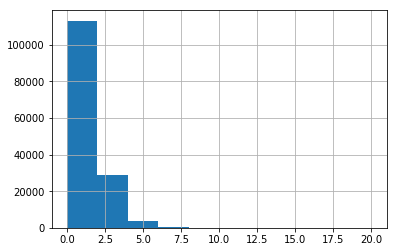

In [241]:
data.NumberOfDependents.hist()

In [242]:
# Counter(data.NumberOfDependents)

On retrouve beaucoup de valeurs NaN. On les remplace par la médiane.

In [243]:
data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

In [244]:
data.NumberOfDependents[data.NumberOfDependents.isnull()]

Series([], Name: NumberOfDependents, dtype: float64)

In [245]:
Counter(data.NumberOfDependents)

Counter({2.0: 19522,
         1.0: 26316,
         0.0: 90826,
         3.0: 9483,
         4.0: 2862,
         5.0: 746,
         6.0: 158,
         8.0: 24,
         7.0: 51,
         20.0: 1,
         10.0: 5,
         9.0: 5,
         13.0: 1})

Les valeurs supérieures à 10 sont probablement des erreurs car très rares.

In [246]:
data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

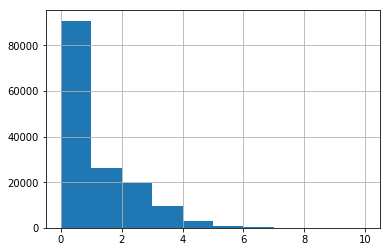

In [247]:
data.NumberOfDependents.hist()

### RevolvingUtilizationOfUnsecuredLines

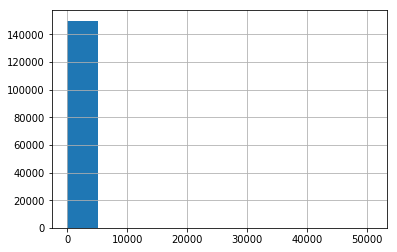

In [248]:
data.RevolvingUtilizationOfUnsecuredLines.hist()

In [249]:
data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()

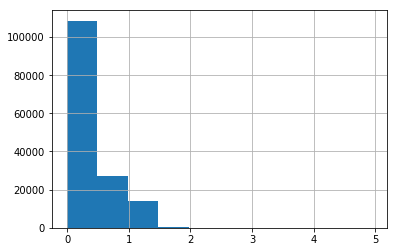

In [250]:
data.RevolvingUtilizationOfUnsecuredLines.hist()

### DebtRatio

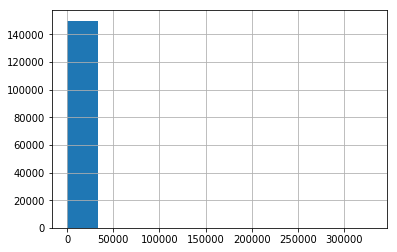

In [251]:
data.DebtRatio.hist()

In [252]:
# Counter(data.DebtRatio)

In [253]:
data.loc[
    data.DebtRatio > 1,
    'DebtRatio',
] = data.DebtRatio.median()

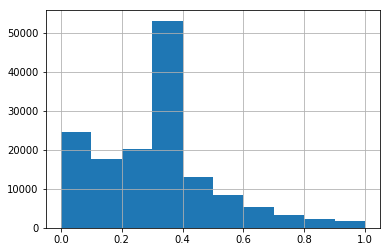

In [254]:
data.DebtRatio.hist()

In [255]:
data.DebtRatio.describe()

count    150000.000000
mean          0.317893
std           0.199835
min           0.000000
25%           0.175074
50%           0.366506
75%           0.380021
max           1.000000
Name: DebtRatio, dtype: float64

### MonthlyIncome

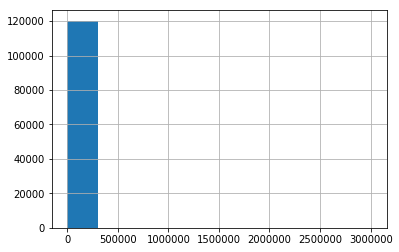

In [256]:
data.MonthlyIncome.hist()

In [257]:
data.MonthlyIncome.describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [258]:
data.loc[
    data.MonthlyIncome > 20000,
    'MonthlyIncome',
] = data.MonthlyIncome.median()

In [259]:
data.loc[data.MonthlyIncome.isnull(), 'MonthlyIncome'] = data.MonthlyIncome.median()

In [260]:
data.MonthlyIncome.describe()

count    150000.000000
mean       5901.911800
std        3297.785678
min           0.000000
25%        3903.000000
50%        5400.000000
75%        7100.000000
max       20000.000000
Name: MonthlyIncome, dtype: float64

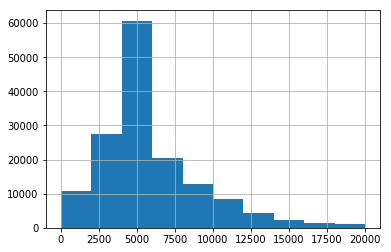

In [261]:
data.MonthlyIncome.hist()

### NumberOfOpenCreditLinesAndLoans

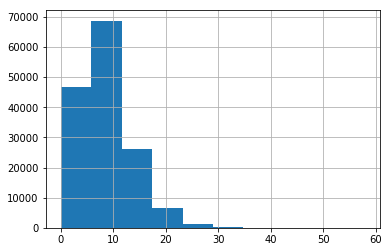

In [262]:
data.NumberOfOpenCreditLinesAndLoans.hist()

In [263]:
data.NumberOfOpenCreditLinesAndLoans.describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

Il ne semble pas y avoir d'erreurs manifestes.

### NumberOfTime60-89DaysPastDueNotWorse

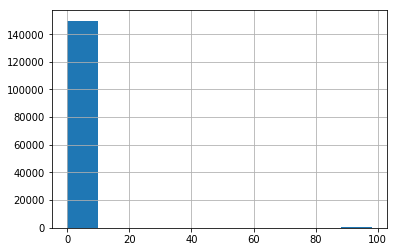

In [264]:
data["NumberOfTime60-89DaysPastDueNotWorse"].hist()

In [265]:
data["NumberOfTime60-89DaysPastDueNotWorse"].describe()

count    150000.000000
mean          0.240387
std           4.155179
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

In [266]:
Counter(data["NumberOfTime60-89DaysPastDueNotWorse"])

Counter({0: 142396,
         1: 5731,
         2: 1118,
         5: 34,
         3: 318,
         98: 264,
         4: 105,
         6: 16,
         7: 9,
         8: 2,
         96: 5,
         11: 1,
         9: 1})

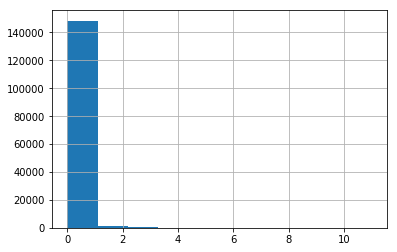

In [267]:
data.loc[
    data["NumberOfTime60-89DaysPastDueNotWorse"] > 20,
    "NumberOfTime60-89DaysPastDueNotWorse",
] = data["NumberOfTime60-89DaysPastDueNotWorse"].median()
data["NumberOfTime60-89DaysPastDueNotWorse"].hist()

## Vérifications

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12be71358>,
      dtype=object)

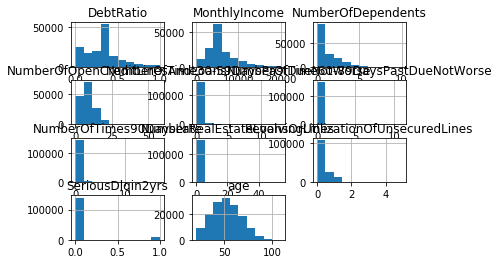

In [268]:
data.hist()

## Nouvelle visualisation

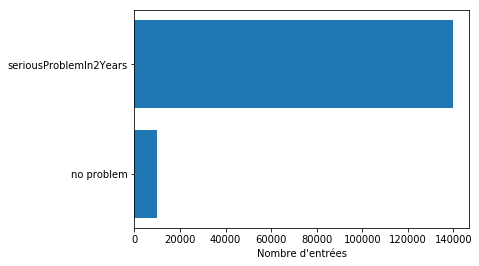

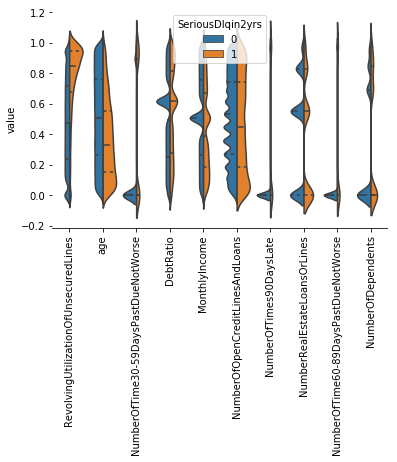

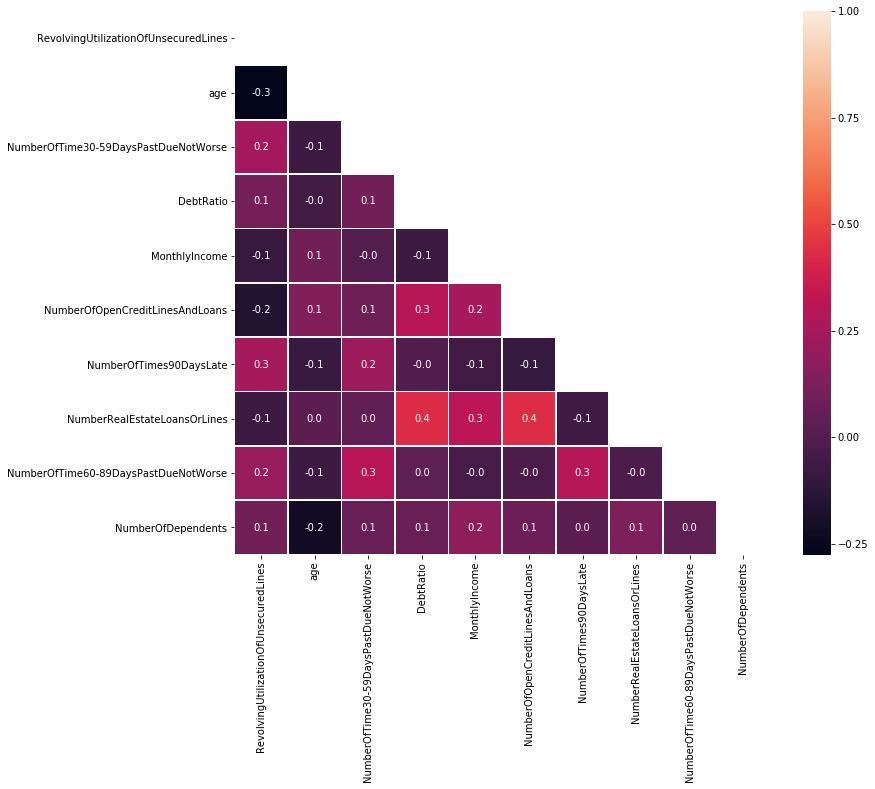

In [269]:
visualization(data)

### Distribution des features
Après élimination des outliers, on ne remarque pas de différence notable dans la distribution des features, ce qui est normal puisque le Scaler QuantileTransform a été appliqué et que celui-ci est censé réduire l'influence des outliers.

## Nouvel essai d'entrainement de modèles

In [58]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


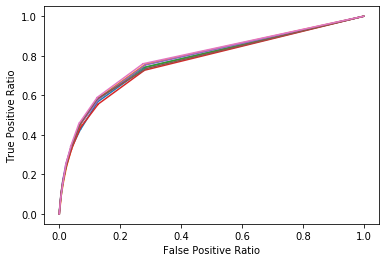

Mean: 0.778818


In [59]:
eval_model(RandomForestClassifier(), X, y)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

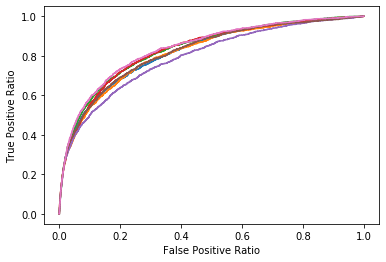

Mean: 0.822092


In [60]:
eval_model(LogisticRegression(), X, y)

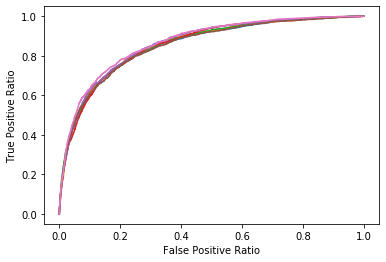

Mean: 0.858341


In [61]:
eval_model(AdaBoostClassifier(), X, y)

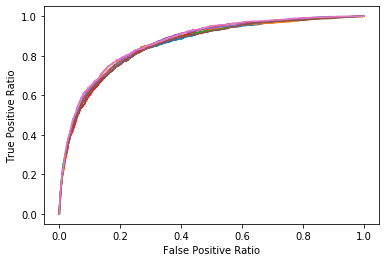

Mean: 0.862747


In [62]:
eval_model(GradientBoostingClassifier(), X, y)

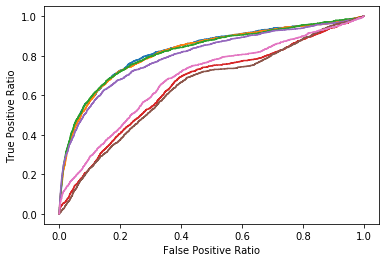

Mean: 0.750258


In [63]:
eval_model(MLPClassifier(), X, y)

On remarque une amélioration des modèles, en particulier sur la régression logistique où la différence de qualité de prédiction est tout à fait étonnante. Les résultats donnés par MLP sont mauvais, probablement parce que ce modèle demande un choix d'hyper-paramètres soignés.

## Optimisation du GradientBoostingClassifier

On utilise Grid Search pour déterminer les meilleurs hyper parametres. Nous allons essayer d'optimiser sur les paramètres suivants :
- n_estimators
- max_depth
- min_samples_split

### n_estimator

In [64]:
from sklearn.model_selection import GridSearchCV

In [65]:
parameters = {'n_estimators': range(50,301,50)}
# parameters = {'n_estimators': range(300,701,100)}
# parameters = {'n_estimators': range(250,350,25)}
# parameters = {'n_estimators': range(260,290,5)}

gs = GridSearchCV(GradientBoostingClassifier(), parameters, scoring='roc_auc')
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 250} 0.862974277722792


### max_depth

In [66]:
parameters = {'max_depth': range(2,5,1)}
gs = GridSearchCV(GradientBoostingClassifier(
    n_estimators=270,
), parameters, scoring='roc_auc')
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 3} 0.8629714067955015


### min_samples_split

In [67]:
parameters = {'min_samples_split': range(2,4,1)}
gs = GridSearchCV(GradientBoostingClassifier(
    n_estimators=270,
    max_depth=3,
), parameters, scoring='roc_auc')
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'min_samples_split': 2} 0.8629790191351001


Remarque : Notre démarche est très discutable. Nous cherchons la meilleure valeur d'un hyper-paramètre en considérant que les autres sont constants. C'est chaques combinaisons des hyper-paramètres qu'il faudrait calculer, mais cela est extrêmement coûteux en temps de calcul.

### Evaluation

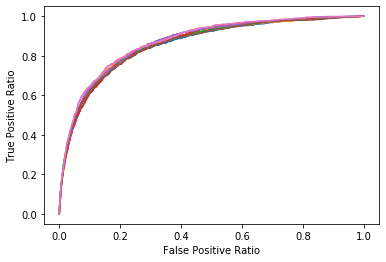

Mean: 0.863726


In [68]:
clf = GradientBoostingClassifier(
    n_estimators=270,
    max_depth=3,
    min_samples_split=3,
)
eval_model(clf, X, y)

## Utilisation d'un modèle pour nettoyer les données 

Pour le moment, le défaut majeur de notre travail repose sur notre choix de valeurs pour remplacer les données fausses/abérantes.

In [69]:
def plot_feature_importance(clf, X_train, y_train, feature_names=feature_names):
    '''
        Given a classifier clf and a fitting set (X, y), fit the clf 
        and plot the importance of each feature.
        
        clf: classifier with feature_importances_ attribute. 
    '''
    clf.fit(X, y)
    feature_importance = dict(zip(feature_names, clf.feature_importances_))
    sorted_feature_importance = np.array(sorted(feature_importance.items(), key=lambda x: x[1]))

    plt.barh(sorted_feature_importance[:, 0], sorted_feature_importance[:, 1].astype(float))
    plt.xlabel('Feature importance')
    plt.show()

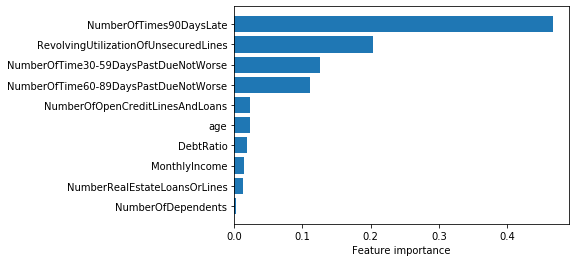

In [70]:
X_train, y_train, _, _ = train_test_split(X, y, test_size=0.9, random_state=random_state)
plot_feature_importance(clf, X_train, y_train)

Remarquons que la feature `RevolvingUtilizationOfUnsecuredLines` a bien l'importance que nous avions présentie lors de la visualisation des données avec les diagrammes violons. Plus étonnant cependant, la feature âge n'ait pas si discriminante que nous l'avions présenti.

Par ailleurs, il est étonnant que la feature `MonthlyIncome` soit aussi peu déterminante dans la classification. En remplaçant toutes les données NaN par la médiane dans le dataset, il est possible que nous ayons rendu la feature non utilisable. Nous proposons donc de réaliser une prédiction de cette feature en utilisant les autres colonnes de X.

In [71]:
### loading dataset
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)
data.loc[data.NumberOfDependents.isnull(), 'NumberOfDependents'] = data.NumberOfDependents.median()

### cleaning
data.loc[data.age < 21, 'age'] = data.age.median()
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()


data.loc[
    data.DebtRatio > 1,
    'DebtRatio',
] = data.DebtRatio.median()

data.loc[
    data["NumberOfTime60-89DaysPastDueNotWorse"] > 20,
    "NumberOfTime60-89DaysPastDueNotWorse",
] = data["NumberOfTime60-89DaysPastDueNotWorse"].median()



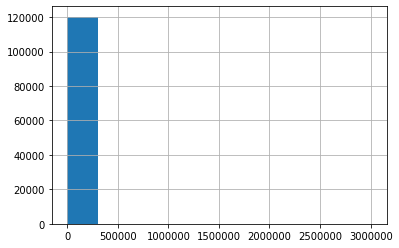

In [72]:
data.MonthlyIncome.hist()

In [73]:
data.MonthlyIncome.describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [74]:
number_of_lines_with_null_monthly_income = len(data[data.MonthlyIncome.isnull()==True])
number_of_lines = len(data)
'{} lines out of {} have null monthly income'.format(
    number_of_lines_with_null_monthly_income, number_of_lines
)

'29731 lines out of 150000 have null monthly income'

On supprime les lignes avec un monthly income nul.

In [75]:
data = data[data.MonthlyIncome.isnull()==False]
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000,1.202690e+05,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000
mean,0.069486,0.332884,51.290224,0.261239,0.309738,6.670221e+03,8.758475,0.091395,1.054519,0.067299,0.851724
std,0.254280,0.359637,14.425926,0.718683,0.216876,1.438467e+04,5.172835,0.488939,1.149273,0.336365,1.147135
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035084,40.000000,0.000000,0.143388,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.175972,51.000000,0.000000,0.296023,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.575464,61.000000,0.000000,0.427013,8.249000e+03,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,4.937063,103.000000,13.000000,1.000000,3.008750e+06,58.000000,17.000000,54.000000,11.000000,10.000000


In [76]:
X = data.drop(['SeriousDlqin2yrs', 'MonthlyIncome'], axis=1)
y = data.MonthlyIncome

In [77]:
from sklearn.ensemble import RandomForestRegressor

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=random_state)

In [79]:
reg = RandomForestRegressor(n_estimators=150, min_samples_split=0.5) 
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.008375428386706463

In [80]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.03840841206324952

In [81]:
reg = linear_model.Lasso()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.03842119437746205

In [82]:
from sklearn.ensemble import AdaBoostRegressor
reg = AdaBoostRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

-0.32912551699106385

In [83]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
#reg.score(X_test, y_test)
np.mean(cross_validate(reg, X, y, cv=5)['test_score'])

0.22549999320308714

In [84]:
from sklearn.dummy import DummyRegressor
reg = DummyRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

-2.0170224640070344e-05

In [85]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.07973711591800559

In [86]:
from sklearn.ensemble import BaggingRegressor
reg = BaggingRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.17188623884443066

In [87]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.024852777097972956

In [88]:
from sklearn.linear_model import ElasticNet
reg = ElasticNet()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.021745941346902775

In [89]:
from sklearn.linear_model import Ridge
reg = Ridge()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.03841335127473644

In [90]:
from sklearn.linear_model import SGDRegressor
reg = SGDRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.0314114273263042

In [91]:
from sklearn.svm import SVR
reg = SVR(kernel='linear')
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.015571102355532718

In [92]:
reg = SVR(kernel='rbf')
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


-0.006669834699982058

In [93]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.2104825437605643

In [94]:
MontlyIncomes = reg.predict(X)

In [95]:
### loading dataset
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)
data.loc[data.NumberOfDependents.isnull(), 'NumberOfDependents'] = data.NumberOfDependents.median()

### cleaning
data.loc[data.age < 21, 'age'] = data.age.median()
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()


data.loc[
    data.DebtRatio > 1,
    'DebtRatio',
] = data.DebtRatio.median()

data.loc[
    data["NumberOfTime60-89DaysPastDueNotWorse"] > 20,
    "NumberOfTime60-89DaysPastDueNotWorse",
] = data["NumberOfTime60-89DaysPastDueNotWorse"].median()

data = data[data.MonthlyIncome.isnull()==True]
X = data.drop(['SeriousDlqin2yrs', 'MonthlyIncome'], axis=1)
y = data.MonthlyIncome
MonthlyIncome = reg.predict(X)

In [96]:
### loading dataset
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)
data.loc[data.NumberOfDependents.isnull(), 'NumberOfDependents'] = data.NumberOfDependents.median()

### cleaning
data.loc[data.age < 21, 'age'] = data.age.median()
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()


data.loc[
    data.DebtRatio > 1,
    'DebtRatio',
] = data.DebtRatio.median()

data.loc[
    data["NumberOfTime60-89DaysPastDueNotWorse"] > 20,
    "NumberOfTime60-89DaysPastDueNotWorse",
] = data["NumberOfTime60-89DaysPastDueNotWorse"].median()

data.loc[
    data.MonthlyIncome.isnull(),
    'MonthlyIncome',
] = MonthlyIncome

In [97]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

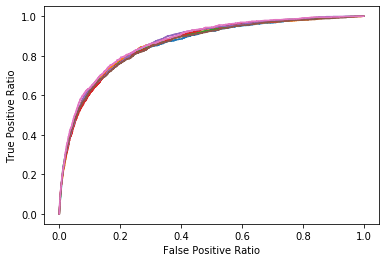

Mean: 0.863121


In [98]:
eval_model(GradientBoostingClassifier(
    n_estimators=270,
    max_depth=3,
    min_samples_split=3,
), X, y)

In [99]:
from sklearn.model_selection import GridSearchCV
best_params = {}

In [100]:
parameters = {'n_estimators': range(55, 65, 1)}
# parameters = {'n_estimators': range(300,701,100)}
# parameters = {'n_estimators': range(250,350,25)}
# parameters = {'n_estimators': range(260,290,5)}

gs = GridSearchCV(GradientBoostingRegressor(), parameters, scoring='neg_mean_squared_error', verbose=True)
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)
best_params = {**best_params, **gs.best_params_}

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.8min finished


{'n_estimators': 64} -0.04947898960933201


In [101]:
print(best_params)

{'n_estimators': 64}


In [102]:
parameters = {'max_depth': range(2,5,1)}
gs = GridSearchCV(GradientBoostingRegressor(
    **best_params
), parameters, scoring='neg_mean_squared_error', verbose=True)
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)
best_params = {**best_params, **gs.best_params_}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   56.2s finished


{'max_depth': 4} -0.04945967650692043


In [103]:
parameters = {'min_samples_split': range(2,4,1)}
gs = GridSearchCV(GradientBoostingRegressor(
    **best_params
), parameters, scoring='neg_mean_squared_error', verbose=True)
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)
best_params = {**best_params, **gs.best_params_}

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   54.5s finished


{'min_samples_split': 3} -0.0494527048838619


In [104]:
print(best_params)

{'n_estimators': 64, 'max_depth': 4, 'min_samples_split': 3}


In [105]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(**best_params)
reg.fit(X_train, y_train)
#reg.score(X_test, y_test)
np.mean(cross_validate(reg, X, y, cv=5)['test_score'])

0.20697926658721988

Utilisons le GradientBoostingRegressor que nous venons d'entrainer pour remplacer les valeurs inconnues.

In [106]:
### loading dataset
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)
data.loc[data.NumberOfDependents.isnull(), 'NumberOfDependents'] = data.NumberOfDependents.median()

### cleaning
data.loc[data.age < 21, 'age'] = data.age.median()
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()


data.loc[
    data.DebtRatio > 1,
    'DebtRatio',
] = data.DebtRatio.median()

data.loc[
    data["NumberOfTime60-89DaysPastDueNotWorse"] > 20,
    "NumberOfTime60-89DaysPastDueNotWorse",
] = data["NumberOfTime60-89DaysPastDueNotWorse"].median()

In [107]:
data_nan = data[data.MonthlyIncome.isnull()].drop('MonthlyIncome', axis=1).drop('SeriousDlqin2yrs', axis=1)
print(data_nan)

        RevolvingUtilizationOfUnsecuredLines   age  \
6                                   0.305682  57.0   
8                                   0.116951  27.0   
16                                  0.061086  78.0   
32                                  0.083418  62.0   
41                                  0.072898  81.0   
52                                  1.000000  62.0   
58                                  0.541109  43.0   
62                                  0.101156  72.0   
71                                  0.142013  67.0   
86                                  0.360510  58.0   
92                                  0.784836  52.0   
96                                  0.542243  48.0   
100                                 0.013025  61.0   
109                                 0.041258  61.0   
115                                 0.007508  74.0   
118                                 0.007521  68.0   
124                                 0.277957  39.0   
130                         

In [108]:
for index, row in data_nan.iterrows():
    MonthlyIncome_predicted = reg.predict(np.array(row).reshape(1, -1))
    print(MonthlyIncome_predicted)
    data.loc[index, 'MonthlyIncome'] = MonthlyIncome_predicted

[5302.04830365]
[-470.34972163]
[2833.26864522]
[1946.73917789]
[494.50993577]
[4907.64284287]
[1662.42159691]
[3498.95610634]
[3802.33311213]
[4208.77372755]
[4345.38374285]
[191.94382242]
[111.68319479]
[5538.73180205]
[-609.96257868]
[-91.23832766]
[4002.5863495]
[1946.88408344]
[2504.7782565]
[202.01102704]
[346.9662795]
[1891.03519141]
[2212.80920557]
[-215.65539999]
[1877.29986294]
[2219.78956974]
[2516.13843303]
[-616.61392351]
[2026.19997562]
[600.64047262]
[2348.56177882]
[4459.25057367]
[5774.10515111]
[1956.76888571]
[1991.56028796]
[2128.64708235]
[4345.38374285]
[523.99347864]
[1766.12716701]
[687.45824995]
[6393.76404099]
[2879.70087248]
[283.21322743]
[5301.59880333]
[2128.64708235]
[1548.66914241]
[1373.25806476]
[7745.78540696]
[668.37126656]
[4101.25981865]
[2371.46874652]
[901.5228052]
[4345.38374285]
[3822.42838621]
[4146.07934543]
[1126.90332686]
[-935.31548006]
[2138.00024171]
[2760.22239058]
[848.2671132]
[-4.56129507]
[4250.63148637]
[847.92382138]
[3874.4597351

[1409.47430277]
[2258.55523703]
[5252.27219626]
[2610.58925769]
[4064.25032634]
[-183.07478241]
[162.6718656]
[4150.319177]
[1517.45575403]
[854.50946071]
[4172.17176182]
[3416.71019078]
[-175.70486445]
[741.93880285]
[3956.99841406]
[3915.32587008]
[930.27857597]
[3186.67197833]
[-108.53828958]
[1656.7849605]
[720.57236072]
[5408.9977341]
[423.90467601]
[2008.04957519]
[5095.28414125]
[1029.95017884]
[1654.4786254]
[1991.70361023]
[1381.99291495]
[6672.55208908]
[231.8353485]
[1832.87531779]
[1724.49086371]
[1540.06089594]
[3822.42838621]
[2942.53757551]
[2451.71594091]
[4948.16152305]
[-307.67247005]
[5170.01090715]
[2087.24528285]
[1642.77567312]
[4301.27990133]
[1841.18147104]
[-369.61924962]
[-333.26893272]
[1079.64765509]
[1950.55713478]
[2318.04375934]
[2017.93437745]
[5113.77203139]
[2125.31887954]
[-106.62883623]
[1097.58771246]
[1632.18621214]
[-507.09667407]
[-1188.14250592]
[-73.28554446]
[1968.15079334]
[1724.49086371]
[2016.98316199]
[4002.5863495]
[833.10007869]
[1489.63

[2760.14731678]
[1946.88408344]
[1690.08133855]
[2408.1562944]
[-238.40797979]
[2281.01854226]
[3033.02846908]
[2757.44340726]
[-268.26328678]
[2911.48721202]
[1240.40497519]
[2641.4969193]
[5683.32804694]
[1709.87804913]
[10.2522207]
[2180.61003362]
[2009.14754657]
[3018.18115505]
[627.80837067]
[267.89813467]
[-190.05893732]
[-39.80014249]
[588.63902736]
[-293.10478342]
[37.54416695]
[2266.70065068]
[3706.75232116]
[-893.08346483]
[2258.55523703]
[2235.49617548]
[-597.08882252]
[4025.85371243]
[-7.27535983]
[1387.16090194]
[1437.29714331]
[2084.5516577]
[4606.69862333]
[-414.77936411]
[2771.50634724]
[-195.16280575]
[6527.05391385]
[4127.35223504]
[1967.12944162]
[3925.96389472]
[-175.83696903]
[532.66324739]
[2394.98495812]
[165.51774673]
[2050.23579054]
[-773.06600999]
[4405.39325899]
[908.29249225]
[688.75558941]
[3455.2525992]
[4441.31931079]
[2681.2077878]
[1691.06520749]
[3701.84699586]
[-693.12838971]
[308.23122954]
[799.8712529]
[4194.02268415]
[3346.67615086]
[3651.99327549]

[3510.66142774]
[4229.43725489]
[99.67010437]
[1088.71163418]
[1386.0141948]
[1147.35142042]
[3416.71019078]
[366.24375077]
[1996.89081487]
[-714.70235524]
[2128.91493044]
[4229.43725489]
[786.75832963]
[1556.42095176]
[4595.49349311]
[568.2878216]
[359.5884282]
[3576.71436331]
[1370.60087252]
[1950.55713478]
[542.0388893]
[3213.61901093]
[4345.38374285]
[2093.98020592]
[1464.01506748]
[2274.7651717]
[1775.34398065]
[-197.73891776]
[2992.36232469]
[-146.82788252]
[-935.31548006]
[1488.68397466]
[507.64751368]
[1982.34347432]
[-39.80014249]
[2206.69744112]
[3111.39306615]
[-23.97090278]
[2087.24528285]
[667.40978834]
[1870.69334942]
[117.8369936]
[1704.35563167]
[1024.35559809]
[4555.0379998]
[1622.11214578]
[-225.6906894]
[1465.94355491]
[786.75832963]
[2395.16454105]
[5257.9885076]
[1725.70485671]
[593.49796601]
[3519.33695152]
[1286.55090043]
[1640.71711243]
[5257.30559837]
[110.39400782]
[3925.96389472]
[6337.32599219]
[4871.30324075]
[1126.8496529]
[5798.33232325]
[1030.93479246]
[

[1370.82325947]
[0.37558167]
[5097.19972455]
[4907.64284287]
[1740.03882323]
[541.37887069]
[39.61593227]
[4229.43725489]
[1996.59289826]
[4183.49480923]
[1494.45265126]
[2138.00024171]
[-39.80014249]
[1609.25600697]
[4107.99474172]
[2140.08628689]
[2226.81129866]
[1933.75166334]
[2936.17486092]
[2460.90473772]
[-77.81951404]
[-293.10478342]
[3896.41638124]
[4441.31931079]
[623.6587022]
[2138.00024171]
[5066.69470064]
[3231.92283919]
[2562.37884141]
[434.14252502]
[-73.40924759]
[786.75832963]
[897.51756564]
[2396.16775505]
[4222.96909076]
[161.53691516]
[1657.01054843]
[438.70632503]
[2609.71057976]
[3896.41638124]
[3951.28316615]
[6812.06611259]
[1015.13878446]
[3242.0823368]
[3532.44712259]
[1489.1974083]
[2052.86910197]
[1517.49026936]
[2138.00024171]
[-39.80014249]
[1240.40497519]
[2041.41400833]
[1248.22657158]
[4222.1251739]
[88.49131791]
[110.39400782]
[2464.6910377]
[3779.6592468]
[959.54935925]
[1591.6358072]
[1359.68308292]
[570.65564901]
[4512.70613676]
[369.52805361]
[623.

[4588.12277557]
[-935.31548006]
[1201.72149938]
[1176.91997385]
[3608.7378044]
[2199.01568922]
[111.68319479]
[1672.00620593]
[1011.25217682]
[296.27918514]
[4237.90604307]
[3468.11950019]
[2028.07905868]
[1946.88408344]
[222.67455439]
[4142.92946624]
[-91.23832766]
[3982.92529371]
[1207.13482567]
[1699.29815218]
[790.26838765]
[541.37887069]
[955.01354947]
[-72.24076236]
[5074.19555741]
[-616.61392351]
[2180.61003362]
[6783.06199418]
[-449.5568699]
[1323.53684995]
[1255.22384118]
[4399.55694325]
[2030.48489042]
[3927.98609307]
[3295.80626175]
[4422.1028603]
[1766.12716701]
[4650.85093615]
[-510.82017204]
[-256.00396247]
[3896.41638124]
[4203.14533932]
[3061.99630593]
[1324.7483584]
[1640.22761818]
[1240.40497519]
[-55.42375409]
[-215.65539999]
[1003.06684784]
[3097.69561172]
[1179.52193859]
[-714.70235524]
[4563.29665038]
[-293.10478342]
[4960.30579683]
[3970.7834215]
[2332.36900552]
[-155.22460569]
[-235.05286095]
[1801.08897824]
[2609.71057976]
[3787.83427975]
[1699.29815218]
[415.1

[293.05964852]
[-15.66063341]
[1156.4308651]
[1962.24113778]
[463.25529857]
[2435.34915409]
[1429.35197273]
[1478.95291094]
[4153.29014591]
[2220.66108544]
[10.77359821]
[3725.98008004]
[1478.95291094]
[5561.85331438]
[1097.73125021]
[4146.07934543]
[2043.72755615]
[4048.84507331]
[1684.46819857]
[2757.44340726]
[1640.22761818]
[1328.88752344]
[187.21286868]
[739.21879302]
[3378.49285164]
[2066.58175551]
[1593.08334312]
[3956.99841406]
[1991.70361023]
[3222.49826583]
[3951.13895417]
[2145.12244543]
[1288.20365292]
[1154.56704479]
[3670.06065631]
[4172.17176182]
[1826.14647677]
[2609.71057976]
[1647.07673673]
[4537.01164561]
[3462.48238993]
[2070.89931789]
[958.59249105]
[4740.93558339]
[741.93880285]
[1742.67815025]
[3630.63787415]
[5464.58828955]
[3537.05939145]
[1549.1222288]
[1996.59289826]
[2609.71057976]
[3259.47543409]
[1551.90961678]
[4327.76368023]
[1875.72754301]
[6264.50750086]
[5315.62885534]
[572.97461348]
[1414.66851056]
[1178.32058527]
[2310.40847617]
[262.56656789]
[1866

[588.63902736]
[1209.38939193]
[3401.49615807]
[-572.13508383]
[4365.69616287]
[1590.86339206]
[185.7454317]
[1741.06317054]
[5266.94378543]
[396.81999987]
[-225.6906894]
[3090.00125526]
[-935.31548006]
[1699.29815218]
[1528.19379769]
[668.88645813]
[10.77359821]
[1344.06712024]
[3956.10857679]
[2448.73149768]
[1284.24803827]
[8517.15107379]
[1239.00975794]
[1741.06317054]
[3751.20078543]
[-331.79175477]
[-437.61530486]
[-198.97569182]
[4034.37268904]
[1775.34398065]
[2087.24528285]
[3960.89861924]
[1640.71711243]
[3438.72998217]
[1775.34398065]
[1657.01054843]
[3706.75232116]
[5218.31882222]
[3269.06186759]
[1007.85430558]
[2212.02588694]
[1608.17519889]
[667.40978834]
[4127.35223504]
[1413.60366997]
[1690.08133855]
[-380.6943186]
[1634.6144782]
[854.56981843]
[4127.35223504]
[6295.15265716]
[2879.70087248]
[2281.01854226]
[-8.34312109]
[3309.16902718]
[1137.60167729]
[6248.20233854]
[39.61593227]
[4197.65091535]
[1657.01054843]
[1464.01506748]
[-985.41577691]
[1693.72089377]
[-39.800

[-307.67247005]
[1185.31141877]
[601.37512481]
[3578.93122716]
[432.55267602]
[2414.64601391]
[4563.2359306]
[874.07151315]
[605.11389841]
[3896.41638124]
[4523.83983655]
[1654.4786254]
[699.21503641]
[58.33189828]
[5483.601492]
[5250.60090832]
[859.39154573]
[1319.44538054]
[1996.59289826]
[1918.53763063]
[-297.16583138]
[1030.93479246]
[-565.23604458]
[-203.21985851]
[1725.49026028]
[39.10764865]
[665.81013319]
[3709.14332243]
[5661.15695928]
[4237.90604307]
[124.19459251]
[1991.70361023]
[4034.37268904]
[2522.08328465]
[-66.79596438]
[5195.66170768]
[111.68319479]
[3106.55177787]
[1176.91997385]
[-40.19888496]
[353.43771064]
[-241.72690448]
[-216.61283657]
[4094.98638861]
[3692.63018222]
[352.00047309]
[451.44045086]
[5410.60508084]
[3109.16069595]
[2068.9290125]
[1637.9028699]
[-296.20839479]
[1911.94935893]
[250.69636984]
[730.05194988]
[655.76884529]
[1724.49086371]
[4441.31931079]
[1876.00019714]
[856.60154562]
[4621.3254037]
[4222.1251739]
[-586.58656185]
[1956.76888571]
[514.3

[1273.32157801]
[2017.29500839]
[1870.69334942]
[938.35852183]
[-342.89275783]
[5238.13240345]
[2606.08234856]
[3313.88139437]
[4197.65091535]
[4084.91385368]
[1444.39061294]
[99.67010437]
[344.27401796]
[847.92382138]
[-935.31548006]
[1699.29815218]
[-333.26893272]
[660.38898825]
[3896.41638124]
[4023.13894784]
[1996.59289826]
[848.36830512]
[4186.86211116]
[359.5884282]
[5207.26498918]
[3896.28813987]
[4625.24493388]
[774.52965898]
[2757.44340726]
[6800.15386131]
[-300.68831514]
[2007.39951286]
[3429.28860259]
[1884.80214632]
[866.29711084]
[5.01938429]
[3521.79777975]
[1260.2346406]
[4127.35223504]
[4488.03553084]
[-125.05279104]
[2529.51480055]
[1981.24198825]
[-333.26893272]
[3500.1108577]
[-483.70277194]
[1885.14177199]
[1090.21991656]
[303.80417835]
[4977.62878183]
[-99.56131521]
[213.33844991]
[947.37128601]
[7343.36157533]
[876.46936743]
[2641.4969193]
[1714.81371383]
[741.93880285]
[2757.44340726]
[1814.56205126]
[817.16186124]
[2641.4969193]
[3985.24089231]
[5266.94378543]
[

[1279.94318915]
[3429.28860259]
[1398.12619776]
[39.61593227]
[1876.00019714]
[-198.97569182]
[2128.64708235]
[-406.90028166]
[1449.33790467]
[4965.48771062]
[1858.13905069]
[1841.18147104]
[4282.26397882]
[1445.93993486]
[741.93880285]
[1933.75166334]
[1179.52193859]
[1956.76888571]
[2681.95062094]
[4591.62198838]
[-247.99922239]
[2128.91493044]
[5575.4746169]
[8775.66295876]
[512.60594261]
[1257.08489056]
[4345.38374285]
[161.26217503]
[1345.07819966]
[568.81300543]
[1670.64348401]
[3466.56391115]
[-609.96257868]
[-449.4052875]
[6343.4709754]
[155.32088229]
[1279.00269903]
[858.26461244]
[586.73576972]
[2119.5218182]
[2446.43235345]
[2020.0497624]
[1782.01192368]
[5095.28414125]
[2032.19719469]
[4441.31931079]
[1920.54706979]
[4330.26947332]
[165.77394236]
[1640.71711243]
[758.28557041]
[-256.00396247]
[1209.38939193]
[2546.65692782]
[2471.12649273]
[1200.88858623]
[1095.25895975]
[-344.27386961]
[39.61593227]
[2813.63163722]
[573.80498183]
[1725.49026028]
[1496.64262953]
[5356.31294

[4104.61617021]
[2431.69142455]
[1012.94348687]
[5317.74738914]
[2385.74393215]
[3416.71019078]
[3416.71019078]
[1392.74277195]
[189.81008258]
[1129.68647094]
[332.63128442]
[2394.98495812]
[4025.85371243]
[989.8503483]
[3896.41638124]
[1967.12944162]
[2024.38225619]
[2017.93437745]
[2039.22036143]
[1131.43720051]
[2712.40679651]
[1799.65044811]
[4094.98638861]
[4493.97459897]
[1324.7483584]
[2641.4969193]
[6633.75167643]
[1667.4615066]
[2030.60213419]
[523.00248571]
[2865.4517688]
[2128.91493044]
[3701.84699586]
[1657.01054843]
[4949.5287722]
[4166.44121602]
[2376.07251266]
[2132.06480964]
[721.55448]
[-15.66063341]
[2476.08310811]
[97.15275671]
[-48.21622931]
[4101.25981865]
[4236.89831267]
[210.33727351]
[1198.3874667]
[1024.35559809]
[1384.83577357]
[2254.95467426]
[5021.18242876]
[2408.26723106]
[5349.29762364]
[6545.84815903]
[786.75832963]
[1490.20717557]
[-39.80014249]
[438.70632503]
[-677.95863392]
[4653.27716773]
[-1010.69699756]
[1356.23198647]
[2757.44340726]
[2128.91493044

[4025.85371243]
[-637.04864692]
[2039.73213092]
[1991.56028796]
[3576.71436331]
[-22.78960811]
[5808.98115566]
[4798.99717339]
[1079.83275057]
[1876.00019714]
[4830.25408535]
[4926.87953608]
[1870.48563905]
[2761.11327469]
[3597.45480453]
[2033.46504185]
[1757.83359842]
[4237.90604307]
[1990.00306214]
[-856.95725257]
[5972.28086465]
[354.48455977]
[3715.15234032]
[1583.22588925]
[1514.04103258]
[1545.67438644]
[440.97882888]
[309.38688822]
[1369.56788518]
[2446.43235345]
[2527.36648712]
[5385.56206913]
[4317.83244634]
[1265.43611181]
[3896.41638124]
[160.46847452]
[2006.85492918]
[3728.04409475]
[-339.16977351]
[236.83986928]
[3223.29112813]
[2093.98020592]
[4641.70742647]
[660.38898825]
[148.37168076]
[-375.88587045]
[-96.40015072]
[2757.44340726]
[287.0457055]
[255.76158063]
[-356.05237435]
[5410.60508084]
[261.85793469]
[2230.8765864]
[4494.36875353]
[2466.37929817]
[699.21503641]
[5419.76876277]
[2174.8726718]
[-533.44811248]
[713.29097269]
[2010.83294876]
[-147.59781289]
[3124.001

[324.46770569]
[739.21879302]
[1324.7483584]
[1741.06317054]
[5625.48085271]
[2008.04957519]
[4142.92946624]
[4002.5863495]
[1873.83173873]
[3477.80456834]
[2019.07529213]
[826.74267765]
[10389.2000301]
[1150.41120682]
[1316.69882196]
[2601.73309155]
[3505.70272843]
[2016.98316199]
[342.78365945]
[2520.47113174]
[1982.34347432]
[3301.92363583]
[263.49896723]
[763.70628241]
[1941.83768753]
[5157.47553853]
[2895.96555594]
[39.61593227]
[1000.93668083]
[3732.13029327]
[1517.49026936]
[1991.73320854]
[-39.80014249]
[625.27011327]
[3355.8927506]
[5915.33121228]
[573.80498183]
[3451.34987844]
[5483.32564307]
[236.83986928]
[4115.30682271]
[3155.95992449]
[4625.24493388]
[67.63464932]
[1874.23429456]
[1756.53329794]
[1938.56414494]
[4150.319177]
[2060.68666913]
[1413.60366997]
[3507.11806671]
[1556.42095176]
[3837.68800012]
[1437.29714331]
[1725.49026028]
[5736.83127033]
[254.16660671]
[2023.86980953]
[116.71738838]
[-360.52029078]
[279.64817891]
[63.87854381]
[1180.09953047]
[2208.1106381]
[

[974.72772964]
[5231.78037015]
[1074.76970563]
[119.14981647]
[-698.14759965]
[5468.85724174]
[1464.01506748]
[3571.33595489]
[874.07151315]
[279.64817891]
[-449.5568699]
[2527.36648712]
[763.70628241]
[3397.61544609]
[3329.57495875]
[499.41142614]
[-15.66063341]
[1775.34398065]
[2912.17004616]
[759.46924866]
[278.0386136]
[3852.91155]
[4328.1870944]
[42.07992222]
[-39.80014249]
[806.75997295]
[4926.87953608]
[1988.36472674]
[4034.37268904]
[2641.4969193]
[1201.72149938]
[-357.46207599]
[1763.34860336]
[207.77306213]
[1446.52290936]
[-75.53361051]
[-39.80014249]
[3559.08503322]
[624.43597522]
[-333.26893272]
[-533.44811248]
[2041.41400833]
[-198.97569182]
[5834.19198957]
[-436.13579078]
[4229.43725489]
[1598.95386121]
[4965.48771062]
[-114.10616476]
[457.79379331]
[-216.61283657]
[1902.7445913]
[3426.08458867]
[185.7454317]
[2929.74589627]
[2226.81129866]
[77.81339024]
[-235.84838118]
[794.16206007]
[3550.52225521]
[261.91839152]
[78.46845818]
[1699.29815218]
[-235.05286095]
[-39.80014

[4766.63944389]
[2631.8544457]
[3854.32661998]
[3823.36275394]
[798.16911086]
[-400.74553941]
[5498.28685988]
[4245.05196656]
[3692.63018222]
[1545.67438644]
[3461.52196577]
[897.51756564]
[1863.75420234]
[-98.99011247]
[7256.75189886]
[947.32370701]
[2084.12402322]
[-704.31589675]
[4002.5863495]
[-307.67247005]
[-533.44811248]
[627.80837067]
[3880.72281687]
[815.86485032]
[3936.09799158]
[4907.64284287]
[3404.24784452]
[4799.16993042]
[-905.84211089]
[1858.13905069]
[416.78726063]
[1814.98936294]
[2757.44340726]
[3692.63018222]
[2007.39951286]
[5030.49205027]
[3762.97881927]
[-39.80014249]
[3364.23793191]
[39.61593227]
[-203.21985851]
[6851.71658165]
[860.4992653]
[1279.94318915]
[2976.42901046]
[2016.98316199]
[231.8353485]
[5172.75672321]
[359.72431357]
[627.80837067]
[205.55890629]
[1310.08836097]
[1911.94935893]
[3719.37457639]
[5789.88930218]
[337.49608577]
[1.65054096]
[-198.8073584]
[617.79322836]
[824.72086912]
[749.06875678]
[-312.28767667]
[3653.31247784]
[2032.19719469]
[12

[2446.43235345]
[-261.44484384]
[5343.92145221]
[6463.87533339]
[3493.30830531]
[1479.78845923]
[162.00125012]
[2853.10715345]
[-225.6906894]
[1876.24977968]
[4104.61617021]
[7992.59700932]
[1414.16134711]
[5877.14744332]
[1471.93847961]
[2502.18690486]
[3815.61348855]
[-293.10478342]
[-39.80014249]
[161.53691516]
[1816.92966314]
[1938.56414494]
[1046.81793398]
[5095.28414125]
[894.40355807]
[1615.82193321]
[3327.8454346]
[1741.06317054]
[3404.24784452]
[5856.45898932]
[353.43771064]
[-56.82250232]
[2208.1106381]
[3732.13029327]
[1513.88763545]
[4159.09706674]
[1991.6914079]
[-256.00396247]
[1490.20717557]
[346.9662795]
[4679.10450139]
[3244.10460137]
[619.91614423]
[447.29357919]
[1140.14154083]
[-1.29277465]
[1859.38157805]
[6842.39322635]
[1906.53570765]
[1768.24194985]
[4342.65947867]
[5041.9097294]
[144.04475705]
[-616.61392351]
[-163.71304107]
[3329.57495875]
[56.31111007]
[3592.71437363]
[-1141.60803681]
[-198.97569182]
[2746.26318049]
[161.53691516]
[122.63291702]
[6343.4709754

[2446.43235345]
[1690.08133855]
[5323.25792486]
[1672.00620593]
[5459.00876974]
[693.47933157]
[4034.37268904]
[-346.56880562]
[2138.00024171]
[1390.25832546]
[155.43428093]
[340.01343343]
[1523.77243772]
[3533.0300971]
[1967.12944162]
[4365.69616287]
[1716.27344664]
[1699.29815218]
[1516.53373156]
[2470.38289248]
[108.5441222]
[2181.02286603]
[6030.33634247]
[233.10060246]
[1956.76888571]
[3424.78752366]
[3221.61003369]
[1165.64767874]
[2476.08310811]
[2556.88135007]
[-378.10703745]
[1445.93993486]
[896.62275293]
[6031.1530876]
[1911.45974286]
[1123.53625771]
[2208.1106381]
[3544.3309305]
[78.46845818]
[3652.04124074]
[-292.3914375]
[2732.14839324]
[3851.95101945]
[4441.31931079]
[1959.77394841]
[1654.4786254]
[1591.6358072]
[1902.7445913]
[1381.56560327]
[-449.4052875]
[541.37887069]
[3668.1805631]
[3749.3760415]
[1444.39061294]
[1438.94517202]
[1622.11214578]
[3313.88139437]
[-29.12221482]
[2476.08310811]
[731.03183986]
[2416.38564446]
[1062.27144819]
[1704.35563167]
[3627.56242914]

[263.49896723]
[819.20731689]
[2464.6910377]
[1079.51219525]
[1000.93668083]
[-135.97542651]
[-334.2263693]
[2570.77266854]
[5556.36318194]
[1558.70716224]
[4670.98448776]
[1640.71711243]
[2014.19293813]
[-39.80014249]
[276.84362588]
[3792.15244802]
[452.77027491]
[4783.82700057]
[2321.73967774]
[1478.95291094]
[1770.16983616]
[2335.15085274]
[274.80082175]
[1076.71874301]
[2291.8722065]
[3726.73480591]
[4867.91401775]
[-104.77432716]
[-91.23832766]
[947.37128601]
[1387.83087945]
[1725.49026028]
[3543.06601316]
[-139.96244844]
[-533.44811248]
[3642.77646185]
[39.61593227]
[668.37126656]
[1292.31713804]
[4365.37072428]
[2678.6170965]
[-354.44949382]
[337.49608577]
[1031.01861949]
[468.38368716]
[676.54949155]
[76.6764702]
[1404.16443316]
[3441.59245014]
[1991.6914079]
[1593.11069151]
[-139.37087514]
[170.27362949]
[1066.97789107]
[160.46847452]
[205.01326117]
[2139.92176872]
[-39.80014249]
[1279.94318915]
[-935.31548006]
[3027.43369998]
[221.84576997]
[6427.17501006]
[3639.17665039]
[-6

[1158.63935921]
[-292.64314026]
[677.36761959]
[1668.49205875]
[3588.98485544]
[1404.16443316]
[4003.8353379]
[2270.51480581]
[2087.43106329]
[688.97386242]
[2128.91493044]
[2281.01854226]
[630.53527455]
[375.31192509]
[1182.60679172]
[1718.34577912]
[789.07251339]
[3083.9689516]
[232.23922224]
[1591.6358072]
[1667.4615066]
[-174.43603505]
[4245.05196656]
[1973.11485067]
[153.51039022]
[4142.92946624]
[-935.31548006]
[1498.5869001]
[568.81300543]
[2879.70087248]
[2641.4969193]
[2667.18694408]
[5774.10515111]
[5080.34577064]
[623.6587022]
[1381.99291495]
[0.37558167]
[682.80116006]
[-182.1559235]
[877.04267645]
[2198.71934324]
[-39.80014249]
[1179.52193859]
[3495.05338559]
[77.81339024]
[3767.98192054]
[3627.56242914]
[4907.64284287]
[2476.08310811]
[-354.44949382]
[-773.06600999]
[1691.06520749]
[1690.08133855]
[4563.29665038]
[463.25529857]
[1775.34398065]
[1690.08133855]
[346.9662795]
[4096.33488043]
[-470.18280653]
[1792.87156118]
[4079.95067255]
[1290.25869556]
[799.8712529]
[4960.

[3457.54626982]
[1331.63743587]
[248.22139647]
[4653.27716773]
[235.48230819]
[669.42560973]
[324.46770569]
[1568.29297968]
[1359.68308292]
[817.16186124]
[3701.84699586]
[2146.86752113]
[4031.94891325]
[1644.78529274]
[5395.92377969]
[-197.73891776]
[205.2880013]
[1345.07819966]
[95.12110884]
[3410.75722491]
[276.84362588]
[739.21879302]
[1891.03519141]
[2811.09151917]
[-773.06600999]
[-310.57212193]
[232.23922224]
[2664.37747505]
[3706.14214603]
[1031.24093959]
[2107.25149871]
[97.275897]
[1209.76062822]
[1672.00620593]
[4222.1251739]
[1849.88200976]
[-538.93291005]
[3620.20693594]
[3730.74467739]
[5.01938429]
[1327.94965062]
[3847.15979774]
[2269.77156944]
[1673.2558338]
[63.87854381]
[153.51039022]
[-40.60428073]
[4028.28240247]
[3627.56242914]
[4907.64284287]
[4150.319177]
[1699.29815218]
[4222.1251739]
[431.62517736]
[-964.59800856]
[290.59124617]
[999.65895533]
[1640.71711243]
[4625.24493388]
[-665.49878183]
[3476.90140645]
[4197.65091535]
[346.9662795]
[201.03934375]
[3320.2754

[-220.44200498]
[1106.31781651]
[2026.07979111]
[-175.83696903]
[1849.88200976]
[3443.82639165]
[1201.72149938]
[3309.31678091]
[-675.47155857]
[3074.76543833]
[-339.16977351]
[2298.70805845]
[2208.1106381]
[482.02509865]
[3639.17665039]
[-532.72268093]
[272.10017061]
[1693.72089377]
[1266.30170419]
[6975.68309921]
[205.2880013]
[549.74687987]
[2609.71057976]
[-195.79246172]
[3550.52225521]
[1649.94736476]
[1316.09886517]
[1976.34625525]
[1057.80511781]
[1920.07649651]
[-339.16977351]
[3167.70959093]
[1770.16983616]
[396.81999987]
[4757.08428561]
[3090.00125526]
[4265.20281564]
[3434.74538144]
[1891.03519141]
[1266.30170419]
[4157.52222948]
[2476.08310811]
[-280.94760979]
[-339.16977351]
[-609.96257868]
[4146.07934543]
[1876.00019714]
[-413.13739282]
[1854.05272658]
[-241.72690448]
[3748.54498881]
[2176.95757829]
[3373.83806835]
[4055.54681028]
[4345.38374285]
[3704.30770558]
[2434.22520469]
[4440.90756762]
[4176.987388]
[264.81983982]
[6427.17501006]
[2641.4969193]
[1859.38157805]
[18

[3165.17861353]
[1095.25895975]
[1262.61770359]
[-482.07023354]
[321.1591127]
[1222.0716714]
[3016.64107094]
[2125.31887954]
[261.85793469]
[751.27944192]
[2026.07979111]
[77.81339024]
[40.02704526]
[3550.52225521]
[427.33220271]
[3559.08503322]
[-147.59781289]
[679.58120202]
[354.48455977]
[1858.13905069]
[3767.98192054]
[8135.4246392]
[1448.99809003]
[1858.13905069]
[-111.73550962]
[1973.11485067]
[1774.34458408]
[1635.38440193]
[4691.41166519]
[-15.66063341]
[154.18102735]
[2329.76977499]
[2817.49642315]
[1404.16443316]
[-148.24503672]
[2562.37884141]
[1169.33229741]
[4907.64284287]
[4043.27519141]
[2634.2862676]
[1967.12944162]
[877.3968661]
[-98.44172045]
[3925.96389472]
[-311.61477099]
[4107.41324773]
[1464.01506748]
[1464.01506748]
[-175.83696903]
[586.39934859]
[-817.70194733]
[2052.86910197]
[759.31562627]
[7194.14561372]
[290.59124617]
[1633.08610101]
[-714.70235524]
[1419.11477055]
[1570.73572524]
[205.2880013]
[337.74946586]
[-948.22811427]
[1580.60911096]
[1681.22301956]
[

[2504.7782565]
[1778.17909723]
[3719.37457639]
[4346.83638733]
[749.06875678]
[4197.65091535]
[384.49244458]
[2394.98495812]
[1137.60167729]
[3104.82360047]
[4179.46442851]
[-704.31589675]
[143.94317834]
[650.40309636]
[3858.10113872]
[627.80837067]
[1950.55713478]
[981.38721922]
[-256.00396247]
[-261.44484384]
[3510.31499729]
[4672.95726746]
[4345.38374285]
[4222.1251739]
[1991.6914079]
[4598.56273121]
[125.88141438]
[5587.87380866]
[-542.48086968]
[-216.61283657]
[1518.29486534]
[1556.42095176]
[1649.44443181]
[2000.41085515]
[1335.24926782]
[4028.65207062]
[1138.90328457]
[463.50831857]
[2942.53757551]
[3678.14299493]
[3037.30459829]
[3642.77646185]
[564.24731427]
[319.59483854]
[1699.29815218]
[406.62092408]
[1721.60666516]
[236.7633492]
[2269.77156944]
[1772.77965547]
[-153.64616325]
[240.41895283]
[3970.7834215]
[105.78731109]
[4571.47168333]
[1694.42602983]
[4231.25331067]
[1188.72586458]
[4197.65091535]
[6210.74978316]
[1938.56414494]
[-195.79246172]
[2446.43235345]
[4276.73969

[1681.22301956]
[2641.4969193]
[387.60318623]
[4923.51786305]
[3225.51002996]
[337.74946586]
[1229.13311891]
[2424.72284562]
[5287.35879758]
[1814.98936294]
[4534.26546089]
[2757.44340726]
[245.45799602]
[2043.48711649]
[818.82302069]
[2757.44340726]
[0.37558167]
[97.15275671]
[393.85371928]
[2087.24528285]
[5468.85724174]
[4601.28959256]
[1764.51976557]
[1076.71874301]
[2070.89931789]
[122.63291702]
[2056.47928492]
[1031.24093959]
[5540.53632744]
[1713.35476173]
[2181.02286603]
[2326.21879229]
[1095.63019604]
[337.74946586]
[4002.5863495]
[-39.83247503]
[279.64817891]
[1043.09774613]
[2559.41401719]
[1916.86741433]
[2161.98086315]
[4159.55579612]
[739.21879302]
[-29.81208977]
[5198.27191893]
[1478.95291094]
[3027.43369998]
[1690.08133855]
[28.32735331]
[7767.02911883]
[1775.34398065]
[-247.99922239]
[2464.6910377]
[1259.16956656]
[1775.34398065]
[62.01236104]
[3637.07035325]
[76.6764702]
[5521.44000035]
[1657.01054843]
[4595.49349311]
[2041.41400833]
[1725.49026028]
[3421.75645555]
[1

[2376.07251266]
[1207.13482567]
[3824.60601473]
[3503.08893182]
[-37.0145148]
[-755.06096673]
[4150.319177]
[1209.38939193]
[2164.56542576]
[1098.44808951]
[5562.03255017]
[3329.57495875]
[5155.50469584]
[1866.78338351]
[1766.12716701]
[965.28506409]
[406.62092408]
[-2.73960457]
[1423.11178512]
[-7.21952491]
[1699.29815218]
[1885.14177199]
[767.75992156]
[989.8503483]
[2414.64601391]
[-266.10761763]
[1516.63117352]
[4523.83983655]
[-77.81951404]
[1640.22761818]
[-665.49878183]
[1419.1955407]
[-417.40659844]
[473.14876534]
[1334.70699224]
[1991.70361023]
[2143.74374127]
[5461.83260821]
[-2.73960457]
[5073.97511631]
[6812.06611259]
[5133.65391256]
[-572.13508383]
[-11.57892695]
[5322.16679331]
[264.81983982]
[-724.2546795]
[-388.58836578]
[2157.10521908]
[3881.35287393]
[-7.21952491]
[4965.48771062]
[1205.84005921]
[3951.13895417]
[103.55215398]
[4588.12277557]
[1341.77513717]
[-352.5692738]
[1988.54821539]
[523.00248571]
[4440.81904466]
[-220.44200498]
[3129.59446838]
[3888.59556255]
[3

[4022.06411099]
[4172.17176182]
[661.93659459]
[4197.65091535]
[1660.89591409]
[4724.93082429]
[77.81339024]
[2589.04705241]
[1812.6645961]
[5172.55146287]
[3087.49995629]
[242.91789109]
[953.52063732]
[1445.93993486]
[2070.89931789]
[2087.24528285]
[1403.65614954]
[4024.66396967]
[2026.19997562]
[1575.60704277]
[-334.92382811]
[876.46936743]
[4278.26542754]
[3692.63018222]
[5379.59867177]
[1920.54706979]
[7113.95800043]
[4318.07281802]
[3295.80626175]
[865.61344233]
[1637.9028699]
[117.82499096]
[378.74486725]
[687.78520018]
[659.92374696]
[1305.05313811]
[2926.57529009]
[6311.24008606]
[186.20582235]
[1802.08837481]
[47.34509116]
[-69.68873183]
[1982.34347432]
[-330.84059823]
[1775.34398065]
[3709.95316722]
[1806.12910495]
[50.22930204]
[-19.97707317]
[3936.88883077]
[3701.84699586]
[4503.73025326]
[1891.03519141]
[-41.78721588]
[3113.14896849]
[2087.24528285]
[1917.68428463]
[1774.34458408]
[261.85793469]
[758.28557041]
[116.15108126]
[1920.51415465]
[232.37267744]
[2310.40847617]
[

[2727.28348241]
[1123.53625771]
[3462.48238993]
[4146.07934543]
[4229.43725489]
[1956.76888571]
[6185.69417442]
[3147.14804703]
[3445.24724421]
[5607.99989435]
[122.63291702]
[826.63456201]
[37.45754544]
[299.71029145]
[5095.28414125]
[191.94382242]
[4.35857516]
[1859.38157805]
[1639.14129128]
[1834.66797705]
[2606.08234856]
[-64.14607447]
[1087.62316563]
[7000.62332036]
[-180.2913933]
[2060.68666913]
[1649.44443181]
[3213.83389583]
[5125.1379544]
[858.9417869]
[382.02856685]
[1893.52777767]
[1395.81640242]
[3175.77614246]
[2132.06480964]
[2925.95959629]
[-39.80014249]
[2097.24911475]
[4195.7182773]
[2609.71057976]
[2415.11911772]
[-225.6906894]
[4037.89901998]
[3987.12938647]
[4907.64284287]
[1359.68308292]
[4438.18181047]
[191.94382242]
[2016.98316199]
[-91.59787784]
[2281.01854226]
[3642.77646185]
[4127.35223504]
[4725.13065538]
[463.25529857]
[3754.1888234]
[3747.86405082]
[3111.39306615]
[1741.06317054]
[262.56656789]
[4704.45872567]
[582.42124697]
[-112.62665068]
[1260.5307985]
[

[1438.87879058]
[4262.58302356]
[4248.71226082]
[2476.08310811]
[565.17823586]
[1092.82975985]
[60.05193576]
[1558.70716224]
[2581.04078469]
[-225.6906894]
[4472.46550462]
[1866.78338351]
[2825.36366192]
[4031.24157941]
[2757.44340726]
[-724.2546795]
[135.00680402]
[890.67856018]
[-66.57686919]
[5586.67505888]
[1457.91243325]
[2000.41085515]
[3929.13516826]
[98.28698504]
[5750.40348467]
[-668.52898372]
[4108.70236459]
[4459.25057367]
[2464.6910377]
[2318.04375934]
[3704.16054368]
[4647.27655299]
[1728.85792968]
[2825.36366192]
[4912.69920248]
[-1070.5289732]
[-15.66063341]
[-694.05354033]
[4127.35223504]
[-634.37249205]
[4222.1251739]
[-616.61392351]
[7893.9545779]
[404.4643656]
[3466.56391115]
[117.82499096]
[353.43771064]
[433.7381147]
[11106.07781315]
[1238.34993255]
[1790.91689091]
[3735.95161955]
[5306.51424519]
[6405.71612313]
[232.23922224]
[-39.80014249]
[3367.05371777]
[6612.74718753]
[-301.64575172]
[5250.13677026]
[1659.80481862]
[2361.95267593]
[4028.28240247]
[1455.7647352

[-39.80014249]
[3409.52450837]
[3554.05013092]
[369.52805361]
[3970.7834215]
[1540.06089594]
[3710.51574043]
[4229.43725489]
[5196.92023903]
[708.43185004]
[4523.83983655]
[3457.6194888]
[1770.16983616]
[1382.47487839]
[2540.79661813]
[-732.53427275]
[502.90989695]
[859.39154573]
[2562.37884141]
[103.55215398]
[953.52063732]
[4625.24493388]
[5919.79549035]
[3329.57495875]
[1647.07673673]
[774.52965898]
[374.25048865]
[3775.35836083]
[1161.19746969]
[2070.89931789]
[115.78097314]
[6375.79850789]
[4127.35223504]
[2361.95267593]
[688.97386242]
[502.90989695]
[3466.56391115]
[2609.71057976]
[2911.48721202]
[77.81339024]
[4229.31814888]
[165.51774673]
[4345.38374285]
[2430.66083009]
[1891.03519141]
[3201.83473849]
[1991.6914079]
[-146.82788252]
[4150.319177]
[357.06778917]
[1657.01054843]
[4084.91385368]
[2281.01854226]
[1598.95386121]
[2256.55116149]
[7308.03791078]
[2394.98495812]
[2008.04957519]
[4005.71814602]
[2158.10563014]
[4789.67617557]
[3329.57495875]
[2229.57114693]
[1281.7806158

[5544.35716281]
[897.46998664]
[3462.48238993]
[6152.91599117]
[2576.85122568]
[1557.77355449]
[3559.08503322]
[2839.20442902]
[189.81008258]
[2274.7651717]
[-546.37130477]
[-213.2270655]
[1262.38491039]
[2262.66292594]
[3451.34987844]
[1875.72754301]
[3399.96812019]
[2234.05383233]
[-658.41583661]
[1549.1222288]
[12.63955907]
[-256.00396247]
[53.52481086]
[3991.92707763]
[1891.03519141]
[2128.91493044]
[3985.24089231]
[601.37512481]
[2208.1106381]
[245.45799602]
[4710.08926821]
[74.33028969]
[-538.93291005]
[111.4298147]
[1770.16983616]
[4237.90604307]
[3373.08286882]
[1802.08837481]
[5386.07675665]
[4893.98117653]
[2358.4481803]
[-247.99922239]
[2058.94158886]
[19.46903433]
[2017.93437745]
[5419.86056816]
[2522.67229501]
[5414.18924296]
[2771.50634724]
[-122.5183381]
[1190.94287982]
[161.53691516]
[389.77564218]
[337.06824974]
[1414.16134711]
[832.82359952]
[4237.90604307]
[-751.98602478]
[1583.81198208]
[5167.80036392]
[2598.07259644]
[3204.03222747]
[1649.44443181]
[1876.00019714]


[1612.91827372]
[3682.89229916]
[4443.77682667]
[4638.51730625]
[2353.96087937]
[1339.6093396]
[-120.35313729]
[4441.31931079]
[4164.79156127]
[1991.73320854]
[161.53691516]
[3011.78115956]
[594.62649782]
[3869.95733974]
[141.35321659]
[2000.41085515]
[2376.07251266]
[1706.99171023]
[1455.76473527]
[1814.9564478]
[346.9662795]
[1628.3956256]
[1496.16618907]
[-236.47518902]
[2431.69142455]
[2641.4969193]
[3301.14052673]
[3532.44712259]
[228.0403581]
[2204.63417261]
[4537.01164561]
[7092.77287365]
[947.24739575]
[2122.9941127]
[4058.50459228]
[741.93880285]
[874.07151315]
[2233.09552412]
[2255.27478167]
[588.63902736]
[-77.81951404]
[2643.31297508]
[523.00248571]
[4099.53646517]
[759.31562627]
[1354.0411433]
[3923.18355487]
[5440.97137788]
[2464.6910377]
[897.4269993]
[3495.10096458]
[8254.01514185]
[3543.06601316]
[1848.00352733]
[1393.9971991]
[2486.34052544]
[-21.84499433]
[3466.56391115]
[1258.24357104]
[1888.96107086]
[6206.22855701]
[-215.65539999]
[3922.08125455]
[-470.18280653]
[

[1950.55713478]
[4095.60692376]
[1545.67438644]
[688.75558941]
[4156.70549836]
[2026.07979111]
[150.28460194]
[4345.38374285]
[1981.24198825]
[77.81339024]
[2070.89931789]
[3853.78050746]
[2476.08310811]
[3822.42838621]
[742.74331943]
[1101.6888409]
[4142.92946624]
[9.59239531]
[2361.95267593]
[-949.59319703]
[4229.43725489]
[-198.97569182]
[1057.80511781]
[930.27857597]
[1848.00352733]
[4162.83480952]
[1334.76777061]
[-215.65539999]
[5238.13240345]
[2334.6010655]
[3045.48837704]
[2479.18849507]
[925.37708561]
[3023.1714191]
[-39.80014249]
[5074.24313641]
[4057.31386149]
[974.11568017]
[458.40445014]
[2313.3968578]
[2128.09329124]
[3193.22120455]
[10988.61297636]
[1359.82353256]
[4107.99474172]
[711.58667503]
[1402.98624492]
[3677.41614951]
[2138.00024171]
[2176.18553759]
[-374.1984135]
[462.8279869]
[1025.09278275]
[755.29018217]
[-40.60428073]
[5008.17932016]
[4731.03864648]
[1848.44118547]
[2262.66292594]
[3919.10023614]
[2998.1566387]
[3533.84919953]
[874.07151315]
[216.37201962]
[

[-689.74861656]
[5774.10515111]
[1744.00861851]
[637.88553942]
[3865.24292146]
[2757.44340726]
[2016.09779908]
[-511.33165549]
[843.20686885]
[2414.64601391]
[1545.13926257]
[494.50993577]
[189.81008258]
[5274.04388199]
[1023.47124511]
[1253.16889471]
[3024.89710438]
[4197.65091535]
[5774.10515111]
[3171.79111738]
[232.52342952]
[-60.93837955]
[1455.76473527]
[5908.07083867]
[-597.08882252]
[-307.67247005]
[4345.38374285]
[11515.88650777]
[4949.5287722]
[5359.33236249]
[4031.94891325]
[-114.10616476]
[3636.92221546]
[7423.76601858]
[2527.36648712]
[1390.6916626]
[-188.41444298]
[3591.81983716]
[4115.14619782]
[406.89774353]
[2226.81129866]
[1238.34993255]
[3329.57495875]
[635.10256344]
[1464.01506748]
[353.43771064]
[-930.4506874]
[1764.39329729]
[-400.74553941]
[1866.78338351]
[6667.56394078]
[299.72786109]
[2157.10521908]
[2426.05365093]
[1876.62640392]
[-148.24503672]
[2212.80920557]
[3845.59225706]
[4806.91015373]
[2128.91493044]
[2046.47422104]
[783.29656712]
[3896.41638124]
[135.

[1040.93717643]
[5.01938429]
[4028.28240247]
[2208.1106381]
[2203.54581995]
[157.229465]
[337.74946586]
[3553.48042296]
[4704.45872567]
[4077.5097907]
[3329.57495875]
[1381.56560327]
[77.81339024]
[2425.16298637]
[484.73489624]
[1277.10310533]
[1996.59289826]
[3559.08503322]
[222.93781756]
[4002.5863495]
[4345.38374285]
[2476.08310811]
[827.95741858]
[3550.52225521]
[8581.97357489]
[60.05193576]
[-798.2013549]
[1079.83275057]
[1642.77567312]
[2128.91493044]
[5003.67867546]
[2609.71057976]
[2508.39454484]
[-196.76006882]
[2476.08310811]
[47.34509116]
[4142.92946624]
[821.79120102]
[10791.39011581]
[651.67487028]
[880.4248556]
[59.15993887]
[1741.06317054]
[1823.62620075]
[790.31358534]
[3429.28860259]
[-15.66063341]
[2732.14839324]
[23.15563817]
[623.6587022]
[2157.10521908]
[1024.88587842]
[2361.95267593]
[3326.60752951]
[1445.93993486]
[155.2135346]
[4129.31826352]
[897.46998664]
[2008.04957519]
[3881.39150727]
[2204.63417261]
[-383.51227883]
[-703.51555987]
[1950.55713478]
[4034.3726

[4541.89318118]
[154.18102735]
[2527.36648712]
[1039.03135465]
[4907.64284287]
[1774.34458408]
[3662.42421369]
[-424.86733695]
[337.74946586]
[2419.33759567]
[1590.86339206]
[5915.33121228]
[741.93880285]
[3429.28860259]
[3597.08788217]
[2128.91493044]
[4382.47782398]
[-64.20052105]
[4586.99004314]
[4150.319177]
[2799.68217774]
[4229.43725489]
[3677.41614951]
[5260.9126933]
[2026.19997562]
[1012.94348687]
[2208.1106381]
[2000.41085515]
[319.59483854]
[4122.32931748]
[2138.00024171]
[1540.06089594]
[3996.76780247]
[831.69480637]
[2087.24528285]
[1593.08334312]
[1672.00620593]
[1941.83768753]
[2736.77987992]
[1996.59289826]
[-242.55844454]
[1448.77378038]
[2026.07979111]
[1316.69882196]
[3732.13029327]
[1319.44538054]
[1478.95291094]
[2052.86910197]
[387.60318623]
[1596.88953054]
[4537.01164561]
[3011.78115956]
[512.60594261]
[418.43577179]
[279.64817891]
[-354.44949382]
[1036.08183627]
[5575.4746169]
[2269.77156944]
[5957.92455904]
[573.55602966]
[4377.36387947]
[111.68319479]
[925.3770

[655.76884529]
[1062.27144819]
[3193.22120455]
[5128.34292985]
[1152.37085535]
[2928.90005693]
[711.58667503]
[9066.23231409]
[2394.98495812]
[3642.77646185]
[1946.88408344]
[324.65454212]
[4237.90604307]
[-215.65539999]
[3571.51188871]
[103.55215398]
[741.93880285]
[2679.44763511]
[4656.45279991]
[3594.27334135]
[815.6327971]
[833.10007869]
[4965.48771062]
[6812.06611259]
[-333.26893272]
[-157.81241769]
[1875.72754301]
[3779.6592468]
[3555.19245354]
[4770.22621404]
[1196.34860365]
[2574.24093536]
[2001.1067081]
[1238.34993255]
[4229.43725489]
[1478.95291094]
[5438.94223137]
[3666.52332319]
[2157.10521908]
[369.52805361]
[3721.11965666]
[2070.89931789]
[4503.73025326]
[4345.38374285]
[3630.63787415]
[4563.29665038]
[-112.62665068]
[-935.31548006]
[3951.13895417]
[341.04001504]
[271.08252226]
[2951.38889363]
[4907.64284287]
[1817.66128508]
[36.50029682]
[2176.95757829]
[2128.91493044]
[-830.42856946]
[3106.55177787]
[1806.13092362]
[1527.50192823]
[161.53691516]
[508.4596313]
[-579.5131

[466.04432415]
[1477.36186194]
[3606.67677025]
[588.63902736]
[1741.06317054]
[2555.4029246]
[4338.73634536]
[2100.59832944]
[-29.81208977]
[1090.7908968]
[2206.69744112]
[2129.46855564]
[153.74636445]
[1098.76423062]
[593.49796601]
[1858.13905069]
[2212.80920557]
[4361.56276995]
[296.73788197]
[5086.88370861]
[2052.86910197]
[1601.4363001]
[1878.52372947]
[2848.09488804]
[4528.36747155]
[337.49608577]
[2446.31653257]
[666.88890299]
[387.60318623]
[-182.1559235]
[11.86108277]
[4345.38374285]
[-478.1338235]
[384.49244458]
[3018.18115505]
[2309.71369065]
[1691.06520749]
[1270.80893909]
[-307.67247005]
[4025.85371243]
[-371.08378157]
[2087.24528285]
[741.93880285]
[5659.15464713]
[-213.79270472]
[627.86302758]
[1173.38997808]
[2249.23395578]
[2111.49848334]
[262.56656789]
[2176.95757829]
[1916.86741433]
[1990.36370963]
[1679.67369765]
[1806.13092362]
[5350.45351911]
[5301.46734787]
[4245.05196656]
[1741.06317054]
[601.37512481]
[4513.44293001]
[1948.32274886]
[1448.28707878]
[5998.4934721

[4034.37268904]
[2506.60182575]
[1649.44443181]
[376.25889729]
[3537.77600828]
[661.0237173]
[2999.32125159]
[3746.00382007]
[-99.56131521]
[39.61593227]
[1290.25869556]
[2520.16192743]
[1332.01493835]
[1414.16134711]
[385.18489087]
[3155.09001526]
[2032.19719469]
[3302.52730278]
[-219.13850054]
[1816.92966314]
[235.31508441]
[1299.61605629]
[1478.95291094]
[2641.4969193]
[2476.08310811]
[3627.56242914]
[5739.98158713]
[5652.66315437]
[1640.71711243]
[1610.55637625]
[9062.58774832]
[1657.01054843]
[39.10764865]
[2887.81415911]
[1690.08133855]
[117.8369936]
[4949.35620407]
[2757.44340726]
[3982.92529371]
[600.76950506]
[725.0782253]
[5272.31307294]
[2262.66292594]
[1127.83957733]
[1683.63560423]
[2069.90348277]
[4523.83983655]
[877.3968661]
[3721.11965666]
[1456.69833459]
[2023.86980953]
[2128.91493044]
[3223.29112813]
[55.86484311]
[1303.01548847]
[-641.08886847]
[1507.66371903]
[2041.41400833]
[-64.20052105]
[1079.83275057]
[5784.30978236]
[984.24330266]
[-332.13478432]
[974.72772964]

[767.41035051]
[3526.65168051]
[2311.52017746]
[3736.195581]
[-256.6004004]
[1209.38939193]
[672.62789745]
[1127.83957733]
[872.24982265]
[3662.42421369]
[694.19673422]
[1991.70361023]
[3925.96389472]
[3775.83380041]
[-368.814055]
[-331.79175477]
[-354.44949382]
[-125.95665382]
[1039.70249689]
[4365.37072428]
[301.09325559]
[5095.28414125]
[463.25529857]
[369.52805361]
[1986.27391128]
[1097.73125021]
[2464.6910377]
[3223.29112813]
[11.26794464]
[-157.81241769]
[10.2522207]
[-117.11874693]
[2208.1106381]
[4644.47070801]
[346.9662795]
[3129.59446838]
[-339.16977351]
[191.94382242]
[843.75130638]
[5079.28698035]
[1875.72754301]
[346.36965442]
[-425.54685947]
[39.61593227]
[1996.59289826]
[1085.93555664]
[337.74946586]
[186.20582235]
[5097.36211297]
[4005.71814602]
[-114.10616476]
[4514.39549411]
[3922.08125455]
[3546.56799032]
[2000.41085515]
[12.83920557]
[-449.5568699]
[3927.98609307]
[2074.23597656]
[244.3381281]
[1381.56560327]
[1790.91689091]
[1849.88200976]
[1214.15182419]
[4345.383

[3886.30233668]
[-263.08078587]
[1812.6645961]
[2016.98316199]
[1518.29486534]
[4567.48975824]
[1257.08489056]
[3531.34865564]
[1178.77144149]
[4521.54244645]
[1967.12944162]
[1741.06317054]
[413.4015782]
[53.97213452]
[877.3968661]
[2026.19997562]
[-37.0145148]
[1041.88317862]
[4621.3254037]
[5215.80597124]
[925.37708561]
[3896.41638124]
[3171.45794563]
[-779.69741425]
[387.60318623]
[6419.25052813]
[1625.46076314]
[3626.56808368]
[3662.42421369]
[688.97386242]
[1293.08820252]
[4717.26243927]
[1775.34398065]
[-579.51310257]
[4444.6527523]
[6520.21552438]
[186.20582235]
[5955.21813628]
[4150.9838605]
[1902.7445913]
[1642.77567312]
[406.62092408]
[1913.43979115]
[1991.70361023]
[1640.22761818]
[965.28506409]
[2281.01854226]
[5238.13240345]
[1557.77355449]
[2260.5547558]
[-193.54203787]
[186.20582235]
[-209.21354084]
[2439.36400072]
[1832.87531779]
[2446.43235345]
[2446.43235345]
[1375.47860414]
[2331.55817986]
[3329.84742412]
[1724.49086371]
[-244.22226641]
[186.20582235]
[4877.02581571

[2230.8765864]
[3982.92529371]
[810.6935052]
[-565.23604458]
[913.77296427]
[337.74946586]
[2008.04957519]
[711.58667503]
[4250.63148637]
[120.41990912]
[2641.4969193]
[3776.58852628]
[1303.01548847]
[915.74394941]
[1540.06089594]
[-444.49662554]
[-195.16280575]
[2492.98798998]
[1956.76888571]
[4770.22621404]
[-197.73891776]
[-197.05636721]
[2097.24911475]
[4034.37268904]
[3910.9224716]
[-254.76247562]
[5142.42995179]
[1826.14647677]
[2274.34025219]
[1946.88408344]
[97.15275671]
[4142.92946624]
[-641.08886847]
[-138.40663776]
[3982.92529371]
[1756.27720325]
[319.59483854]
[6130.92598808]
[1283.92409349]
[1266.30170419]
[947.56613046]
[-122.5183381]
[143.46178254]
[271.35989718]
[1286.55090043]
[3787.83427975]
[276.1864164]
[4251.47611667]
[668.88645813]
[1278.97680176]
[2138.00024171]
[467.63160511]
[5434.2914764]
[3901.99590105]
[2008.04957519]
[843.75130638]
[3927.98609307]
[1846.61133758]
[473.14876534]
[3682.92773653]
[3324.89265247]
[1991.70361023]
[2032.19719469]
[-684.83995461]


[1392.74277195]
[127.71667838]
[86.5527521]
[5649.5374734]
[705.20851503]
[-76.67288674]
[5523.99172193]
[418.43577179]
[6802.52985681]
[5723.20744441]
[3985.24089231]
[3322.18553311]
[1786.88668301]
[1352.50365836]
[1545.67438644]
[1059.16634976]
[78.46845818]
[387.60318623]
[1339.6093396]
[9304.25442573]
[3171.45794563]
[2757.44340726]
[2084.02563671]
[3527.62931752]
[4851.35727844]
[106.03460577]
[5382.82908554]
[971.09810145]
[4229.43725489]
[342.78365945]
[3507.11806671]
[3147.14804703]
[2862.26099418]
[1477.36186194]
[2363.80661278]
[1540.06089594]
[1694.42602983]
[2115.88447518]
[1179.52193859]
[799.8712529]
[-307.67247005]
[-37.0145148]
[890.49203649]
[1197.04551405]
[923.14448913]
[1782.01192368]
[3559.08503322]
[3416.71019078]
[132.77899994]
[263.49896723]
[4229.31814888]
[161.53691516]
[2032.19719469]
[24.4294203]
[2000.41085515]
[741.93880285]
[1454.74049205]
[1457.97542041]
[2848.86673649]
[4572.45642573]
[3027.43369998]
[1209.38939193]
[803.1042946]
[1015.13878446]
[4621.

[4034.37268904]
[-220.44200498]
[473.14876534]
[2594.96681903]
[170.27362949]
[1591.6358072]
[1657.01054843]
[3927.98609307]
[8591.95113246]
[245.45799602]
[3730.26014295]
[1699.29815218]
[3661.32261924]
[307.97797838]
[132.88353302]
[1437.7791846]
[774.52965898]
[-39.83247503]
[3597.45480453]
[1233.95730908]
[1858.13905069]
[1239.00975794]
[2414.64601391]
[564.4898555]
[1424.27390732]
[1568.4000561]
[1859.38157805]
[2087.24528285]
[858.73893433]
[3170.54195124]
[2914.16593229]
[6095.14646017]
[3866.68623828]
[3329.57495875]
[7280.19227315]
[2529.98424602]
[1414.16134711]
[2232.3244698]
[1721.83476295]
[2641.4969193]
[1981.24198825]
[3881.88982101]
[-98.99011247]
[2092.73432471]
[-66.57686919]
[1558.70716224]
[1911.94935893]
[477.89361116]
[2879.70087248]
[-229.56973086]
[4276.73969907]
[2562.37884141]
[259.30861904]
[6856.39772231]
[3776.58852628]
[4725.13065538]
[3380.11676463]
[1814.98936294]
[-15.66063341]
[279.87452329]
[2319.62528981]
[1802.08837481]
[-781.68181185]
[858.42090155

[12449.22706325]
[-99.56131521]
[2132.06480964]
[885.98617191]
[5138.99313256]
[1967.12944162]
[43.28696185]
[3616.11094582]
[1590.86339206]
[2160.60465322]
[4625.24493388]
[1341.77513717]
[1127.83957733]
[1725.49026028]
[2508.31941392]
[4523.25166025]
[7365.71696672]
[5821.62119367]
[1654.4786254]
[849.72497327]
[4658.85668755]
[2503.63985638]
[1196.34860365]
[1576.7017329]
[-48.79189732]
[3162.77094509]
[2055.86258572]
[1609.28117566]
[-597.08882252]
[3798.53970459]
[5.01938429]
[573.80498183]
[2052.86910197]
[1792.87156118]
[-37.0145148]
[2520.23661285]
[-751.98602478]
[161.53691516]
[3477.80456834]
[4955.10829201]
[1642.77567312]
[431.62517736]
[2394.98495812]
[4586.7470692]
[3306.41988246]
[1015.13878446]
[2700.2928265]
[18.96528998]
[2174.8726718]
[623.6587022]
[786.75832963]
[5410.60508084]
[-98.99011247]
[43.28696185]
[4229.43725489]
[4025.85371243]
[502.90989695]
[4511.1145017]
[1659.80481862]
[733.7933892]
[2109.28752517]
[1071.12872449]
[2157.10521908]
[-714.70235524]
[739.2

[921.19050395]
[2641.4969193]
[943.58756757]
[3849.3629611]
[-229.56973086]
[1770.16983616]
[1752.86756652]
[2995.29060474]
[1946.18872975]
[-263.08078587]
[4150.319177]
[-357.46207599]
[110.39400782]
[-616.61392351]
[2118.96509194]
[625.27011327]
[3035.15202528]
[-206.17908462]
[135.59696017]
[1478.95291094]
[132.88353302]
[4640.65667821]
[4885.68177513]
[4245.05196656]
[1239.00975794]
[1902.7445913]
[104.9026898]
[59.15993887]
[1062.56673037]
[512.60594261]
[1580.60911096]
[3896.41638124]
[-345.81012279]
[4197.65091535]
[5157.37918891]
[799.8712529]
[-600.2802042]
[2180.61003362]
[1369.30514488]
[749.06875678]
[2230.8765864]
[4634.00103541]
[5911.2099017]
[2187.50494302]
[12.83920557]
[1076.71874301]
[404.79923357]
[3117.89391629]
[3313.88139437]
[1533.95826171]
[4222.1251739]
[3692.63018222]
[1901.9653238]
[959.87429789]
[-209.21354084]
[76.6764702]
[2711.83713842]
[2800.57633508]
[2231.75846422]
[1675.40417574]
[4197.65091535]
[1479.9729747]
[2128.91493044]
[4250.63148637]
[353.437

[1478.95291094]
[3862.64768425]
[2811.09151917]
[4557.19628488]
[3398.2532227]
[4080.39289105]
[111.4298147]
[-264.44141525]
[699.21503641]
[224.73523634]
[655.76884529]
[5095.28414125]
[-293.10478342]
[2562.37884141]
[3661.32261924]
[763.70628241]
[3692.63018222]
[1488.68397466]
[1025.09278275]
[3156.20147941]
[573.80498183]
[2068.15840249]
[2620.62638891]
[2132.06480964]
[-675.47155857]
[847.92382138]
[357.06778917]
[767.41035051]
[3881.39150727]
[4907.64284287]
[1911.45974286]
[359.5884282]
[4621.65431394]
[4029.51836638]
[462.8279869]
[88.49131791]
[2032.19719469]
[4907.64284287]
[541.87988919]
[919.58122615]
[1036.08183627]
[1876.00019714]
[1858.13905069]
[609.11584779]
[721.55448]
[1472.92766637]
[-256.00396247]
[6283.12022733]
[3037.30459829]
[4229.43725489]
[3493.30830531]
[296.47570889]
[1832.87531779]
[5079.28698035]
[2204.63417261]
[2860.03981669]
[1239.00975794]
[2039.22036143]
[771.14455287]
[7061.88438216]
[2757.44340726]
[2794.4761824]
[1026.86502264]
[3982.92529371]
[22

[1896.05080687]
[1257.08489056]
[1031.24093959]
[1478.95291094]
[287.0457055]
[876.46936743]
[1533.95826171]
[2274.7651717]
[1806.13092362]
[3380.11676463]
[1912.38741741]
[6099.35052299]
[-137.76370839]
[2.39492256]
[-675.47155857]
[2232.3244698]
[2052.94436978]
[5.01938429]
[5924.84083106]
[657.0165928]
[201.03934375]
[2204.63417261]
[161.53691516]
[3960.32179953]
[3987.12938647]
[1416.28812527]
[5167.80036392]
[2014.11817095]
[5426.98650438]
[-39.80014249]
[4077.02679681]
[1147.19179368]
[-139.96244844]
[3611.67007671]
[507.64751368]
[3758.51339366]
[5095.28414125]
[2372.68566921]
[258.98465157]
[2009.14754657]
[-215.81405037]
[1015.13878446]
[2128.91493044]
[7355.442995]
[4937.31623783]
[1179.52193859]
[2052.86910197]
[-135.97542651]
[1673.85068653]
[2756.67896431]
[4523.83983655]
[1725.49026028]
[1369.56788518]
[78.46845818]
[279.64817891]
[1690.09402383]
[2448.73149768]
[517.29212851]
[3852.63435475]
[3027.43369998]
[5097.36211297]
[-817.70194733]
[-175.83696903]
[3305.49596318]


[3852.63435475]
[4043.27519141]
[4104.61617021]
[3331.29365439]
[1445.35700034]
[8913.00026709]
[5419.86056816]
[4166.44121602]
[2204.63417261]
[2052.86910197]
[2043.72755615]
[4229.43725489]
[5280.82524184]
[1566.80529011]
[974.50187772]
[-798.2013549]
[1257.9285622]
[4813.55771644]
[434.14252502]
[1818.09567022]
[2284.09885612]
[5527.76829323]
[1982.34347432]
[1134.25068931]
[2070.89931789]
[539.36254152]
[161.53691516]
[2041.41400833]
[1640.22761818]
[-194.84554231]
[-39.80014249]
[858.9417869]
[3027.43369998]
[1518.29486534]
[2057.79960019]
[-665.49878183]
[-215.65539999]
[5101.28244199]
[499.41142614]
[2208.1106381]
[1259.16956656]
[2026.19997562]
[1946.88408344]
[4186.86211116]
[2936.17486092]
[294.75453709]
[789.07251339]
[2825.36366192]
[279.87452329]
[-241.72690448]
[6559.94931451]
[-376.71590169]
[198.09836431]
[209.5250285]
[1659.80481862]
[1911.94935893]
[2650.40220242]
[2017.93437745]
[-63.7187628]
[414.60320238]
[3865.24292146]
[3451.34987844]
[916.6932531]
[1341.61586967

[1286.55090043]
[815.6327971]
[-101.52496781]
[127.71667838]
[125.88141438]
[3982.92529371]
[1680.07727241]
[3970.7834215]
[3862.64768425]
[2.39492256]
[241.68176959]
[-155.22460569]
[3636.77924278]
[733.7933892]
[4288.99312731]
[2455.35723019]
[1832.87531779]
[1980.63117005]
[1988.35200938]
[-175.83696903]
[205.2880013]
[1074.19887994]
[523.00248571]
[236.7633492]
[2353.96087937]
[2697.1927638]
[1580.6145598]
[1072.62173628]
[1664.45966494]
[4049.27375927]
[3116.71723334]
[3067.6115011]
[741.93880285]
[5774.10515111]
[-190.05893732]
[-14.87758211]
[5095.28414125]
[279.64817891]
[-358.77770395]
[1611.62284938]
[151.04798331]
[1363.23142976]
[5498.28685988]
[-15.66063341]
[3483.63945206]
[296.47570889]
[1941.83768753]
[1490.20717557]
[4127.35223504]
[161.53691516]
[451.44045086]
[1374.63593385]
[2936.17486092]
[1523.77243772]
[5250.60090832]
[3670.06065631]
[195.06533283]
[4101.25981865]
[236.7633492]
[5026.76194857]
[5498.28685988]
[857.6291636]
[387.60318623]
[3678.16682768]
[4194.022

[3776.58852628]
[1765.13564257]
[910.23512072]
[74.33028969]
[2132.06480964]
[819.32403919]
[516.65751724]
[6361.02086862]
[-550.91545099]
[3559.08503322]
[2475.44251069]
[1151.51527908]
[-357.60296965]
[1895.23244383]
[6904.16741468]
[4560.78358358]
[3440.15297241]
[77.81339024]
[170.27362949]
[1275.74187339]
[287.0457055]
[3369.99206978]
[1808.20403178]
[457.79379331]
[3936.88883077]
[2562.37884141]
[2332.36900552]
[76.6764702]
[53.97213452]
[3721.11965666]
[3214.53377936]
[2262.66292594]
[1991.6914079]
[1212.26536378]
[370.97271747]
[2464.6910377]
[2606.08234856]
[3951.13895417]
[-85.60632578]
[910.23512072]
[-333.26893272]
[1209.38939193]
[728.75434602]
[5375.85469835]
[2934.96643925]
[1414.16134711]
[2070.89931789]
[-54.20072329]
[-128.91351436]
[4172.17176182]
[2027.51845652]
[1960.15237406]
[3731.15534892]
[554.75602595]
[1774.66981816]
[805.17752201]
[2615.3937101]
[262.56656789]
[659.92374696]
[1946.88408344]
[4107.99474172]
[3228.83304363]
[1423.07653707]
[1866.78338351]
[299

[-293.10478342]
[3712.07504857]
[1404.16443316]
[1934.99723047]
[28.32735331]
[3730.74467739]
[749.06875678]
[-15.00138887]
[1234.23751633]
[1105.17143787]
[387.60318623]
[1159.01715802]
[3706.14214603]
[2562.37884141]
[5073.97511631]
[3219.18924265]
[191.94382242]
[-297.16583138]
[387.60318623]
[749.06875678]
[191.94382242]
[3677.41614951]
[3186.72479729]
[156.72118138]
[3988.19783787]
[488.91216126]
[1040.93717643]
[473.14876534]
[819.32403919]
[1511.0249581]
[880.4248556]
[4564.13041934]
[2951.38889363]
[3696.80505048]
[4172.17176182]
[-240.35397924]
[4606.69862333]
[964.94925258]
[2692.39213223]
[3852.63435475]
[1533.16896509]
[239.30393451]
[2075.46515917]
[6291.4908507]
[3461.52196577]
[6167.25136915]
[-634.37249205]
[3479.86593153]
[132.77899994]
[1296.64255569]
[8819.0471497]
[-369.61924962]
[861.55689456]
[3441.59245014]
[2032.19719469]
[-482.07023354]
[-7.97065162]
[4744.12990445]
[5080.78107438]
[4965.48771062]
[3416.71019078]
[1354.4839861]
[3837.68800012]
[141.35321659]
[4

[1547.12997512]
[2414.64601391]
[-216.61283657]
[-565.23604458]
[4282.26397882]
[2252.69255463]
[2757.44340726]
[-98.06994968]
[4523.25166025]
[-256.00396247]
[1209.38939193]
[4142.92946624]
[1614.15749734]
[40.25823171]
[-275.09185247]
[1946.88408344]
[-1023.45564362]
[2309.71369065]
[-215.65539999]
[-198.97569182]
[92.16461794]
[762.23868622]
[1580.60911096]
[-339.16977351]
[15.27000029]
[-533.44811248]
[2261.52043008]
[2414.64601391]
[363.34592468]
[2578.22732044]
[2321.17059692]
[3713.37735731]
[2540.30904323]
[1188.72586458]
[56.31111007]
[2482.90271835]
[1640.22761818]
[2961.58338726]
[1991.6914079]
[6842.39322635]
[1239.00975794]
[4150.319177]
[6401.86865864]
[693.00709037]
[346.9662795]
[5369.91433632]
[1209.38939193]
[1640.22761818]
[-424.86733695]
[290.63524774]
[2187.39029556]
[7557.05589145]
[2097.24911475]
[1438.87879058]
[2229.57114693]
[233.30158669]
[137.86092467]
[1518.29486534]
[700.88329965]
[4310.96297196]
[1444.39061294]
[1290.25869556]
[4127.35223504]
[-229.349042

[2032.19719469]
[3109.71888333]
[3941.88625592]
[2476.08310811]
[4299.66987247]
[396.81999987]
[803.1042946]
[50.22930204]
[1381.99291495]
[2879.70087248]
[3952.22939489]
[1657.01054843]
[2070.89931789]
[399.76503998]
[232.23922224]
[2757.44340726]
[1286.55090043]
[3670.06065631]
[1005.01198921]
[615.9215177]
[11769.75435637]
[1138.31985033]
[3919.10023614]
[4757.57676069]
[337.74946586]
[7821.43470913]
[3423.28521727]
[2030.48489042]
[1288.20365292]
[138.39433792]
[4096.33488043]
[2562.37884141]
[2540.18408311]
[523.00248571]
[2248.67043477]
[191.94382242]
[337.74946586]
[1002.42158385]
[5827.56487868]
[3566.36523205]
[2450.3687937]
[5052.3492085]
[1716.27344664]
[3213.61901093]
[1229.11303279]
[6399.2317572]
[2443.5749769]
[2641.4969193]
[1814.98936294]
[2625.7943197]
[2470.38289248]
[2665.16733465]
[3368.10457841]
[4907.64284287]
[-935.31548006]
[2223.41795735]
[3896.41638124]
[4034.37268904]
[1816.92966314]
[1388.91299184]
[3434.77757161]
[655.71065406]
[2648.88614366]
[1208.022168

In [109]:
print(data)

        SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines   age  \
0                      1                              0.766127  45.0   
1                      0                              0.957151  40.0   
2                      0                              0.658180  38.0   
3                      0                              0.233810  30.0   
4                      0                              0.907239  49.0   
5                      0                              0.213179  74.0   
6                      0                              0.305682  57.0   
7                      0                              0.754464  39.0   
8                      0                              0.116951  27.0   
9                      0                              0.189169  57.0   
10                     0                              0.644226  30.0   
11                     0                              0.018798  51.0   
12                     0                              0.010352  

[150000 rows x 11 columns]


In [110]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

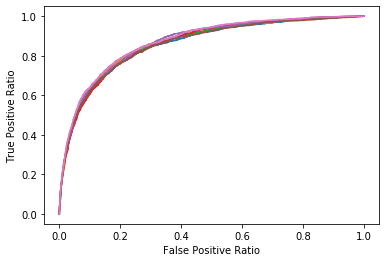

Mean: 0.863271


In [111]:
eval_model(clf, X, y)

Pas de réel amélioration : on met en place le même raisonnement avec la feature `NumberOfTimes90DaysLate`.

In [114]:
### loading dataset
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)
data.loc[data.NumberOfDependents.isnull(), 'NumberOfDependents'] = data.NumberOfDependents.median()

### cleaning
data.loc[data.age < 21, 'age'] = data.age.median()
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()


data.loc[
    data.DebtRatio > 1,
    'DebtRatio',
] = data.DebtRatio.median()

data.loc[
    data.MonthlyIncome.isnull(),
    'MonthlyIncome',
] = data.MonthlyIncome.median()

data.loc[
    data["NumberOfTime60-89DaysPastDueNotWorse"] > 20,
    "NumberOfTime60-89DaysPastDueNotWorse",
] = data["NumberOfTime60-89DaysPastDueNotWorse"].median()

data = data[data.NumberOfTimes90DaysLate.isnull()==False]
X = data.drop(['SeriousDlqin2yrs', 'NumberOfTimes90DaysLate'], axis=1)
y = data.NumberOfTimes90DaysLate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=random_state)

In [115]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.14224182161719467

In [116]:
parameters = {'n_estimators': range(55, 65, 1)}
# parameters = {'n_estimators': range(300,701,100)}
# parameters = {'n_estimators': range(250,350,25)}
# parameters = {'n_estimators': range(260,290,5)}

gs = GridSearchCV(GradientBoostingRegressor(), parameters, scoring='neg_mean_squared_error', verbose=True)
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)
best_params = {**best_params, **gs.best_params_}

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished


{'n_estimators': 61} -0.19581171682809387


In [117]:
print(best_params)

{'n_estimators': 61, 'max_depth': 4, 'min_samples_split': 3}


In [118]:
parameters = {'max_depth': range(2,5,1)}
gs = GridSearchCV(GradientBoostingRegressor(
    **best_params
), parameters, scoring='neg_mean_squared_error', verbose=True)
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)
best_params = {**best_params, **gs.best_params_}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   51.6s finished


{'max_depth': 4} -0.19579180418059042


In [119]:
parameters = {'min_samples_split': range(2,4,1)}
gs = GridSearchCV(GradientBoostingRegressor(
    **best_params
), parameters, scoring='neg_mean_squared_error', verbose=True)
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)
best_params = {**best_params, **gs.best_params_}

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   55.4s finished


{'min_samples_split': 3} -0.19584333567154008


In [120]:
reg = GradientBoostingRegressor(**best_params)
reg.fit(X_train, y_train)
#reg.score(X_test, y_test)
np.mean(cross_validate(reg, X, y, cv=5)['test_score'])

0.17033557538108302

In [121]:
### loading dataset
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)
data.loc[data.NumberOfDependents.isnull(), 'NumberOfDependents'] = data.NumberOfDependents.median()

### cleaning
data.loc[data.age < 21, 'age'] = data.age.median()
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()


data.loc[
    data.DebtRatio > 1,
    'DebtRatio',
] = data.DebtRatio.median()

data.loc[
    data.MonthlyIncome.isnull(),
    'MonthlyIncome',
] = data.MonthlyIncome.median()

data.loc[
    data["NumberOfTime60-89DaysPastDueNotWorse"] > 20,
    "NumberOfTime60-89DaysPastDueNotWorse",
] = data["NumberOfTime60-89DaysPastDueNotWorse"].median()

data = data[data.NumberOfTimes90DaysLate.isnull()==False]
X = data.drop(['SeriousDlqin2yrs', 'NumberOfTimes90DaysLate'], axis=1)
NumberOfTimes90DaysLate = reg.predict(X)

In [122]:
### loading dataset
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)
data.loc[data.NumberOfDependents.isnull(), 'NumberOfDependents'] = data.NumberOfDependents.median()

### cleaning
data.loc[data.age < 21, 'age'] = data.age.median()
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()


data.loc[
    data.DebtRatio > 1,
    'DebtRatio',
] = data.DebtRatio.median()

data.loc[
    data.MonthlyIncome.isnull(),
    'MonthlyIncome',
] = data.MonthlyIncome.median()

data.loc[
    data["NumberOfTime60-89DaysPastDueNotWorse"] > 20,
    "NumberOfTime60-89DaysPastDueNotWorse",
] = data["NumberOfTime60-89DaysPastDueNotWorse"].median()

data.loc[
    data["NumberOfTimes90DaysLate"],
    "NumberOfTimes90DaysLate",
] = NumberOfTimes90DaysLate

X = data.drop(['SeriousDlqin2yrs'], axis=1)
y = data.SeriousDlqin2yrs


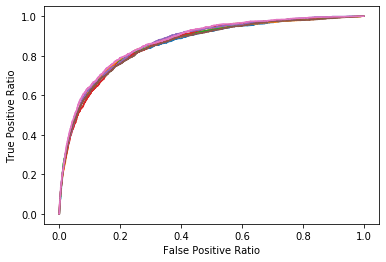

Mean: 0.863697


In [123]:
eval_model(clf, X, y)